In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import itertools
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# # Set the desired working directory
# new_working_directory = '/content/drive/My Drive'

# # Change the current working directory
# os.chdir(new_working_directory)

In [3]:
df = pd.read_csv('2.22 combined dataset of stock data and balance sheet data.csv')

In [4]:
series_list = []
for i in range(1,(df[df['company_name'] == df['company_name'].unique()[0]].shape[0])+1):
  series_list.append(i)
temp = pd.DataFrame({'fiscal_quarter': series_list * (len(df['company_name'].unique()))})
df['fiscal_quarter'] = temp['fiscal_quarter']
df["datadate"] = pd.to_datetime(df["datadate"])


In [5]:
df.shape[1]

17

In [6]:
### These are function producing the estimated parameters used in the Zhou(2001) model
def get_companies():
  return df['company_name'].unique()

def get_industries():
  return df['industry_name'].unique()

def get_date():
  return df['datadate'].unique()

def get_num_quarter():
  return len(df['fiscal_quarter'].value_counts())

def get_country_codes():
  return df['iso_country_code'].unique()

def get_companies_from_industry(industry):
  return df[df['industry_name'] == industry]['company_name'].unique()

def get_companies_from_country(country):
  return df[df['iso_country_code'] == country]['company_name'].unique()

def get_finance_companies(country):
  return df[(df['is_finance']==True)&(df['iso_country_code'] == country)]['company_name'].unique().tolist()
def get_non_finance_companies(country):
  return df[(df['is_finance']==False)&(df['iso_country_code'] == country)]['company_name'].unique().tolist()
    
def get_Vi0(start,company1,company2):
  '''
  This function takes the a start date and two company names to return the starting value of assets
  Output: [v_company1_0,v_company_2_0]
  '''
  v_10 = df[(df['company_name'] == company1)&(df['datadate'] == start)]['total_assets'].item()
  v_20 = df[(df['company_name'] == company2)&(df['datadate'] == start)]['total_assets'].item()
  return v_10,v_20

def get_Ki(start,company1,company2):
  '''
  This function takes the a start date and two company names to return the starting value of Ki := short-term liability + 50% long-term liability
                                                                                                 = total liability -50% long-term liability
  Output: k_company1,k_company_2
  '''
  total_liability_1 = df.loc[(df['company_name'] == company1)&(df['datadate'] == start),['total_liabilities']].iloc[0,0]
  total_liability_2 = df.loc[(df['company_name'] == company2)&(df['datadate'] == start),['total_liabilities']].iloc[0,0]
  # long_term_liability_1 = df.loc[(df['company_name'] == company1)&(df['datadate'] == start),['long_term_liabilities']].iloc[0,0]
  # long_term_liability_2 = df.loc[(df['company_name'] == company2)&(df['datadate'] == start),['long_term_liabilities']].iloc[0,0]
  return  0.75*total_liability_1,0.75*total_liability_2

def get_t(start,end):
  '''
  This function takes the start date and end date of a time horizon and return t
  in Zhou(2001) formula
  Output: t(in years)
  '''
  start_idx = np.where(df['datadate'] == start)[0][0]
  end_idx = np.where(df['datadate'] == end)[0][0]
  return (end_idx - start_idx)/4

def get_sigma_i(company):
  '''
  This function returns the estimated asset volatility of a firm
  '''
  vol_sum = 0
  company_idx = df[df['company_name'] == company].index.tolist()
#   print(company_idx)
  for i in range(company_idx[0],company_idx[-1],4):
    close_list = df.iloc[i:i+4,15]
#     print(close_list,close_list.pct_change()[1:].std())
    vol_sum += close_list.pct_change()[1:].std()
#     print(vol_sum,close_list.pct_change()[1:].std())
  return vol_sum/18
#   close_list = df[(df['datadate'] >= start) & (df['datadate'] <= end)&(df['company_name'] == company)]['Close']
#   close_pct = close_list.pct_change()[1:]
#   #print(close_list)
#   return close_pct.std()


def get_rho(start,end,companies,column,company_1 = None,company_2 = None):
  '''
  This function takes the start date and end date of a time frame and returns the correlation matrix of asset value in a given time horizon
  Note companies is a numpy array containing the name of companies
  Output: A list object:[whole correlation matrix, corr(companyname1,companyname2)] if company_1 and company_2 specified
          the whole correlation matrix otherwise
  '''
  diff_matrix = np.zeros((int(get_t(start,end)*4),len(companies)))
  for i in [i for i in range(0,len(companies))]:
    col_val = np.diff(np.log(df[(df['datadate'] >= start) & (df['datadate'] <= end)&(df['company_name'] == companies[i])][column]))
    diff_matrix [:,i]= col_val
  diff_matrix = pd.DataFrame(diff_matrix)
  corr_df  = diff_matrix.corr()
  if company_1 == None and company_2 == None:
    return corr_df
  else:
    company_1_idx = companies.tolist().index(company_1)
    company_2_idx = companies.tolist().index(company_2)
    output = corr_df[company_1_idx][company_2_idx]
    return output

In [7]:
# for i in range(len(get_companies())):
#     print(get_sigma_i(get_companies()[i]),df[df['company_name'] == get_companies()[i]]['iso_country_code'].unique())

In [8]:
[1,2,3,4][-1]

4

In [9]:
df.iloc[8:12,15]

8     0.148503
9     0.122849
10    0.119236
11    0.108396
Name: Close, dtype: float64

In [10]:
# len(get_rho('2018-12-31','2023-12-31',get_companies(),'Close').stack()[get_rho('2018-12-31','2023-12-31',get_companies(),'Close').stack()<0].index.tolist())

In [11]:
get_rho('2022-12-31','2023-12-31',get_companies(),'Close').head()

,0,1,2,3,4,5,6,7,8,9,...,189,190,191,192,193,194,195,196,197,198
0,1.000000,0.724718,0.455059,0.575937,0.031124,0.539944,0.095339,0.462645,0.390358,0.414682,...,-0.992242,0.127747,-0.710391,-0.287893,0.034374,-0.397688,-0.904740,-0.931681,-0.250171,-0.121653
1,0.724718,1.000000,0.938650,0.843601,0.657884,0.901318,0.654220,0.924741,0.768915,0.899346,...,-0.802987,-0.007817,-0.344963,0.412505,0.089435,-0.302574,-0.528401,-0.756781,-0.788623,0.230694
2,0.455059,0.938650,1.000000,0.867503,0.871386,0.943866,0.850935,0.992061,0.866046,0.986329,...,-0.556342,0.037396,-0.178009,0.629956,0.207937,-0.098397,-0.206227,-0.566395,-0.848549,0.450221
3,0.575937,0.843601,0.867503,1.000000,0.794486,0.983013,0.857804,0.919972,0.977378,0.920585,...,-0.633335,0.507818,-0.609002,0.219011,0.609555,0.248353,-0.201659,-0.793390,-0.475093,0.685518
4,0.031124,0.657884,0.871386,0.794486,1.000000,0.853901,0.986362,0.892950,0.890808,0.918304,...,-0.133437,0.248155,-0.049152,0.697498,0.471325,0.322327,0.290256,-0.270671,-0.665860,0.761697


In [12]:
df.tail(10)

,datadate,key,fiscal_quarter,fiscal_year,total_assets,total_liabilities,isin,company_name,gic_industries,iso_country_code,industry_name,is_finance,Open,High,Low,Close,Volume
14318,2021-09-30,319369.0,63,2021,0.946,0.173,VGG870911077,TECHFINANCIALS INC,351010.0,VGB,Health Care Equipment & Supplies,False,154.589986,187.096677,151.091282,166.703029,89083600.0
14319,2021-12-31,319369.0,64,2021,0.946,0.173,VGG870911077,TECHFINANCIALS INC,351010.0,VGB,Health Care Equipment & Supplies,False,167.019524,182.951209,154.724160,177.976656,44589900.0
14320,2022-03-31,319369.0,65,2022,0.772,0.162,VGG870911077,TECHFINANCIALS INC,351010.0,VGB,Health Care Equipment & Supplies,False,159.227848,159.973698,107.218288,133.465010,68940300.0
14321,2022-06-30,319369.0,66,2022,0.772,0.162,VGG870911077,TECHFINANCIALS INC,351010.0,VGB,Health Care Equipment & Supplies,False,134.793372,140.300990,98.030703,106.836117,68482000.0
14322,2022-09-30,319369.0,67,2022,0.610,0.106,VGG870911077,TECHFINANCIALS INC,351010.0,VGB,Health Care Equipment & Supplies,False,106.833032,122.462094,86.734999,87.530163,57407300.0
14323,2022-12-31,319369.0,68,2022,0.610,0.106,VGG870911077,TECHFINANCIALS INC,351010.0,VGB,Health Care Equipment & Supplies,False,88.158904,111.733486,83.834791,102.176052,75622600.0
14324,2023-03-31,319369.0,69,2023,0.544,0.113,VGG870911077,TECHFINANCIALS INC,351010.0,VGB,Health Care Equipment & Supplies,False,103.939346,110.173410,86.563935,91.995112,64035750.0
14325,2023-06-30,319369.0,70,2023,0.544,0.113,VGG870911077,TECHFINANCIALS INC,351010.0,VGB,Health Care Equipment & Supplies,False,91.412314,108.127419,89.477927,101.220657,72028025.0
14326,2023-09-30,319369.0,71,2023,0.544,0.113,VGG870911077,TECHFINANCIALS INC,351010.0,VGB,Health Care Equipment & Supplies,False,100.625465,111.487810,82.571155,84.406349,52633725.0
14327,2023-12-31,319369.0,72,2023,0.544,0.113,VGG870911077,TECHFINANCIALS INC,351010.0,VGB,Health Care Equipment & Supplies,False,84.195553,97.637076,64.219259,95.677894,76355600.0


In [13]:
stats.norm.cdf(1.96)

0.9750021048517795

In [14]:
# default_rates = [0.01, 0.09, 0.28, 0.46, 0.62, 0.83, 1.06, 1.31, 1.61, 1.96, 2.3, 2.65, 2.99, 3.29, 3.62, 3.95, 4.26, 4.58, 4.96, 5.23]
# default_rates = [x / 100 for x in default_rates]
# default_rates[4]

In [15]:
# def default_prob_loss(z):
#   return sum([((2*sp.stats.norm.cdf(-z/math.sqrt(t))-default_rates[t])/t)**2 for t in range(1,20)])

In [16]:
# y_list = []
# x_list = np.arange(7.75,7.85, 0.01).tolist()

# for z in x_list:
#   y_list.append(sum([((2*sp.stats.norm.cdf(-z/math.sqrt(t))-default_rates[t])/t)**2 for t in range(1,20)]))
# plt.plot(x_list,y_list,label = 'loss function')
# plt.ylim(0.0000218,0.000022)
# plt.legend()
# plt.show()

In [17]:
# default_prob_loss(2)

In [18]:
# sp.optimize.minimize(default_prob_loss,x0=10)

In [19]:
# def f(x):
#   return x**2-4
# sp.optimize.minimize(f,x0=10)

In [20]:
mean = [0, 0]
cov = [[1, 0.4], [0.4, 1]]
stats.multivariate_normal(mean, cov).cdf([1,1])

0.7362527858598517

In [21]:
np.linalg.eig([[0.16,0.064],[0.064,0.16]])[0]

array([0.224, 0.096])

In [22]:
def get_decorr_li_wrong(v1,v2,k1,k2,t,sigma1,sigma2,rho):
    p1 = stats.norm.cdf(-(math.log(v1/k1)/(sigma1*math.sqrt(t)))-(0*math.sqrt(t)/sigma1))+ \
                            (v1/k1)**(2*0/(sigma1**2))*stats.norm.cdf(-(math.log(v1/k1)/(sigma1*math.sqrt(t)))+(0*math.sqrt(t)/sigma1))
    p2 = stats.norm.cdf(-(math.log(v2/k2)/(sigma2*math.sqrt(t)))-(0*math.sqrt(t)/sigma2))+ \
                            (v2/k2)**(2*0/(sigma2**2))*stats.norm.cdf(-(math.log(v2/k2)/(sigma2*math.sqrt(t)))+(0*math.sqrt(t)/sigma2))
    # print(stats.norm.cdf(-(math.log(v1/k1)/(sigma1*math.sqrt(t)))))
    # print(stats.norm.cdf(-(math.log(v2/k2)/(sigma2*math.sqrt(t)))))
    b1 = -math.log(k1/v1)
    b2 = -math.log(k2/v2)
    mean = [0,0]
    cov_rho = [[1,rho],[rho,1]]
    cov_minus_rho = [[1,-rho],[-rho,1]]
    mvn_rho = stats.multivariate_normal(mean, cov)
    mvn_minus_rho = stats.multivariate_normal(mean, cov_minus_rho)
    twod_norm_1 = mvn_rho.cdf([b1/(sigma1*math.sqrt(t)),b2/(sigma2*math.sqrt(t))])
    twod_norm_2 = mvn_minus_rho.cdf([-b1/(sigma1*math.sqrt(t)),b2/(sigma2*math.sqrt(t))])
    twod_norm_3 = mvn_rho.cdf([-b1/(sigma1*math.sqrt(t)),-b2/(sigma2*math.sqrt(t))])
    two_d_norm_4 = mvn_minus_rho.cdf([b1/(sigma1*math.sqrt(t)),-b2/(sigma2*math.sqrt(t))])
    two_d_norm_sum = twod_norm_1-twod_norm_2+twod_norm_3-two_d_norm_4
    or_prob = 1-two_d_norm_sum
    default_corr = (p1+p2-p1*p2-or_prob)/math.sqrt((p1*p2*(1-p1)*(1-p2)))
    return default_corr,p1,p2,or_prob

def get_decorr_li_right(v1,v2,k1,k2,t,sigma1,sigma2,rho):
    covariance_matrix = [[sigma1**2,rho*sigma1*sigma2],[rho*sigma1*sigma2,sigma2**2]]
    eigv1_sqrt = math.sqrt(np.linalg.eig([[0.16,0.064],[0.064,0.16]])[0][0])
    eigv2_sqrt =  math.sqrt(np.linalg.eig([[0.16,0.064],[0.064,0.16]])[0][1])
    # print(eigv1_sqrt,eigv2_sqrt)
    # eigenvalue1 = math.sqrt((1/2)*((sigma1**2)+(sigma2**2)+ \
    #                   math.sqrt((sigma1**2-sigma2**2)**2+4*rho*sigma1*sigma2)))
    # eigenvalue2 = math.sqrt((1/2)*((sigma1**2)+(sigma2**2)+ \
    #                   math.sqrt((sigma1**2-sigma2**2)**2-4*rho*sigma1*sigma2)))
    p1 = stats.norm.cdf(-(math.log(v1/k1)/(eigv1_sqrt*math.sqrt(t)))-(0*math.sqrt(t)/eigv1_sqrt))+ \
                            (v1/k1)**(2*0/(sigma1**2))*stats.norm.cdf(-(math.log(v1/k1)/(eigv1_sqrt*math.sqrt(t)))+(0*math.sqrt(t)/eigv1_sqrt))
    p2 = stats.norm.cdf(-(math.log(v2/k2)/(eigv2_sqrt*math.sqrt(t)))-(0*math.sqrt(t)/eigv2_sqrt))+ \
                            (v2/k2)**(2*0/(sigma2**2))*stats.norm.cdf(-(math.log(v2/k2)/(eigv2_sqrt*math.sqrt(t)))+(0*math.sqrt(t)/eigv2_sqrt))
    # print(stats.norm.cdf(-(math.log(v1/k1)/(eigv1_sqrt*math.sqrt(t)))-(0*math.sqrt(t)/eigv1_sqrt)))
    # print(stats.norm.cdf(-(math.log(v2/k2)/(eigv2_sqrt*math.sqrt(t)))-(0*math.sqrt(t)/eigv2_sqrt)))
    b1 = -math.log(k1/v1)
    b2 = -math.log(k2/v2)
    mean = [0,0]
    cov_rho = [[1,rho],[rho,1]]
    cov_minus_rho = [[1,-rho],[-rho,1]]
    mvn_rho = stats.multivariate_normal(mean, cov)
    mvn_minus_rho = stats.multivariate_normal(mean, cov_minus_rho)
    twod_norm_1 = mvn_rho.cdf([b1/(sigma1*math.sqrt(t)),b2/(sigma2*math.sqrt(t))])
    twod_norm_2 = mvn_minus_rho.cdf([-b1/(sigma1*math.sqrt(t)),b2/(sigma2*math.sqrt(t))])
    twod_norm_3 = mvn_rho.cdf([-b1/(sigma1*math.sqrt(t)),-b2/(sigma2*math.sqrt(t))])
    two_d_norm_4 = mvn_minus_rho.cdf([b1/(sigma1*math.sqrt(t)),-b2/(sigma2*math.sqrt(t))])
    two_d_norm_sum = twod_norm_1-twod_norm_2+twod_norm_3-two_d_norm_4
    or_prob = 1-two_d_norm_sum
    default_corr = (p1+p2-p1*p2-or_prob)/math.sqrt((p1*p2*(1-p1)*(1-p2)))
    return default_corr,p1,p2,or_prob

def analyse_two_companies_li(start,end,companies,company1,company2,prob_sub = 0.9):
  '''
  This function returns the default correlation between 2 companies in a given time horizon by using the
  closed form formula from Zhou(2001)
  prob_sub is the subsituting probability if one of the marginal probability is greater than 1
  '''
  ### get the essential parameter for Zhou's either probability default
  # print(companies.tolist().index(company1),companies.tolist().index(company2))
  v1 = get_Vi0(start,company1,company2)[0]
  v2 = get_Vi0(start,company1,company2)[1]
  k1 = get_Ki(start,company1,company2)[0]
  k2 = get_Ki(start,company1,company2)[1]
  sigma1 = get_sigma_i(company1)
  sigma2 = get_sigma_i(company2)
  rho = get_rho(start,end,companies,'Close',company1,company2)
#   print(rho)
  t = get_t(start,end)
#   print(f'v1/k1:{round(v1/k1,1)},v2/k2:{round(v2/k2,1)},sigma1:{round(sigma1,2)},sigma2:{round(sigma2,2)},rho:{round(rho,2)},t:{t}')
#   covariance_matrix = [[sigma1**2,rho*sigma1*sigma2],[rho*sigma1*sigma2,sigma2**2]]
#   eigv1_sqrt = math.sqrt(np.linalg.eig([[sigma1**2,rho*sigma1*sigma2],[rho*sigma1*sigma2,sigma2**2]])[0][0])
#   eigv2_sqrt = math.sqrt(np.linalg.eig([[sigma1**2,rho*sigma1*sigma2],[rho*sigma1*sigma2,sigma2**2]])[0][1]) 
    # print(eigv1_sqrt,eigv2_sqrt)
    # eigenvalue1 = math.sqrt((1/2)*((sigma1**2)+(sigma2**2)+ \
    #                   math.sqrt((sigma1**2-sigma2**2)**2+4*rho*sigma1*sigma2)))
    # eigenvalue2 = math.sqrt((1/2)*((sigma1**2)+(sigma2**2)+ \
    #                   math.sqrt((sigma1**2-sigma2**2)**2-4*rho*sigma1*sigma2)))
#   print(f'{company2},v1/k1:{round(v1/k1,1)},v2/k2:{round(v2/k2,1)},sigma1:{round(sigma1,2)},sigma2:{round(sigma2,2)},rho:{round(rho,2)},t:{t}')
  p1 = stats.norm.cdf(-(math.log(v1/k1)/(sigma1*math.sqrt(t)))-(0*math.sqrt(t)/sigma1))+ \
                            (v1/k1)**(2*0/(sigma1**2))*stats.norm.cdf(-(math.log(v1/k1)/(sigma1*math.sqrt(t)))+(0*math.sqrt(t)/sigma1))
  p2 = stats.norm.cdf(-(math.log(v2/k2)/(sigma2*math.sqrt(t)))-(0*math.sqrt(t)/sigma2))+ \
                            (v2/k2)**(2*0/(sigma2**2))*stats.norm.cdf(-(math.log(v2/k2)/(sigma2*math.sqrt(t)))+(0*math.sqrt(t)/sigma2))
 
    # print(stats.norm.cdf(-(math.log(v1/k1)/(eigv1_sqrt*math.sqrt(t)))-(0*math.sqrt(t)/eigv1_sqrt)))
    # print(stats.norm.cdf(-(math.log(v2/k2)/(eigv2_sqrt*math.sqrt(t)))-(0*math.sqrt(t)/eigv2_sqrt)))
  if(p1 >=1) or (p1 == 0):
    p1 = 2
  if (p2 >=1) or (p2==0):
    p2 = 2
  if (rho >= 0.95) or (rho <= -0.95):
    return 1.5,p1,p2
  b1 = -math.log(k1/v1)
  b2 = -math.log(k2/v2)
  mean = [0,0]
  cov_rho = [[1,rho],[rho,1]]
  cov_minus_rho = [[1,-rho],[-rho,1]]
#   print(f'rho_mat:{cov_rho},-rho_mat:{cov_minus_rho},p1:{p1},p2:{p2}')
  mvn_rho = stats.multivariate_normal(mean, cov)
  mvn_minus_rho = stats.multivariate_normal(mean, cov_minus_rho)
  twod_norm_1 = mvn_rho.cdf([b1/(sigma1*math.sqrt(t)),b2/(sigma2*math.sqrt(t))])
  twod_norm_2 = mvn_minus_rho.cdf([-b1/(sigma1*math.sqrt(t)),b2/(sigma2*math.sqrt(t))])
  twod_norm_3 = mvn_rho.cdf([-b1/(sigma1*math.sqrt(t)),-b2/(sigma2*math.sqrt(t))])
  two_d_norm_4 = mvn_minus_rho.cdf([b1/(sigma1*math.sqrt(t)),-b2/(sigma2*math.sqrt(t))])
  two_d_norm_sum = twod_norm_1-twod_norm_2+twod_norm_3-two_d_norm_4
  or_prob = 1-two_d_norm_sum if 1-two_d_norm_sum < 1 else 2
  if (p1==2) or (p2==2)or(or_prob==2):
    default_corr = 1.5
    return default_corr,p1,p2,or_prob
  else:
    default_corr = (p1+p2-p1*p2-or_prob)/math.sqrt((p1*p2*(1-p1)*(1-p2)))
    return default_corr,p1,p2,or_prob




def get_decorr_two_group_companies_li(start,end,company_list1,company_list2,prob_sub=0.9,show_non_normal = None):
  companies = get_companies()
  if company_list1 != company_list2:
    combination_list =  list(itertools.product(company_list1,company_list2))
  else:
    combination_list = list(filter(lambda x: x[0]!=x[1],list(itertools.combinations(company_list1,2))))
  # print(len(company_list1),len(company_list2),len(combination_list))
  # print(company_list1)
  # print(company_list2)
  print(len(combination_list))
  num_pairs = len(combination_list)
  corr_sum = 0
  not_normal_sum = 0
  non_normal_dic = {}
  for (firm1,firm2) in combination_list:
    result = analyse_two_companies_li(start,end,companies,firm1,firm2,prob_sub)
    corr = result[0]
    # print(corr_sum)
    prob_default_1 = result[1]
    prob_default_2 = result[2]
    # print(corr,prob_default_1,prob_default_2)
    # print(abs(corr)>1)
#     print(corr)
    if (abs(corr) > 1):
      num_pairs -= 1
      corr_sum += 0
      non_normal_dic[corr] = [prob_default_1,prob_default_2]
    else:
      corr_sum += corr
  if show_non_normal == 'Yes':
    return non_normal_dic
  else:
    return corr_sum/num_pairs if num_pairs != 0 else None

In [23]:
analyse_two_companies_li('2018-12-31','2023-12-31',get_companies(),get_companies()[3],get_companies()[88],prob_sub=0.9)

(0.006284473488801167,
 0.4823987951675437,
 1.5810442479946312e-05,
 0.48239449224342523)

## Get financial coefficient

In [24]:
def get_finance_corr_li(start,end,country,prob_sub=0.9):
  companies = get_companies()
  company_list_financial = df[(df['iso_country_code'] == country)&(df['is_finance'] == True)]['company_name'].unique().tolist()
  if (len(company_list_financial) <= 1):
    return None
  else:
    return get_decorr_two_group_companies_li(start,end,company_list_financial,company_list_financial)

In [25]:
def get_finance_corr_matrix_li(start,end,prob_sub=0.9):
  countries = get_country_codes()
  mat = pd.DataFrame({'country':countries,'finance_corr':[0 for i in range(len(countries))]})
  for i in range(len(countries)):
    mat.at[i,'finance_corr'] = get_finance_corr_li(start,end,get_country_codes()[i])
  return mat

In [63]:
get_finance_corr_matrix_li('2006-12-31','2023-12-31',prob_sub=0.9)

6
36
21
6
28


,country,finance_corr
0,ARG,NaN
1,PER,NaN
2,CUW,NaN
3,BRA,0.573294
4,CHL,0.102326
5,COL,0.003563
6,JAM,NaN
7,CYM,NaN
8,MEX,0.312132
9,PAN,NaN


In [27]:
get_finance_corr_matrix_li('2022-12-31','2023-12-31',prob_sub=0.9)

6
36
21
6
28


,country,finance_corr
0,ARG,0.674785
1,PER,NaN
2,CUW,NaN
3,BRA,0.194607
4,CHL,0.001752
5,COL,0.002521
6,JAM,NaN
7,CYM,NaN
8,MEX,0.031572
9,PAN,NaN


In [67]:
get_finance_corr_matrix_li('2012-12-31','2016-12-31',prob_sub=0.9)

6
36
21
6
28


,country,finance_corr
0,ARG,NaN
1,PER,NaN
2,CUW,NaN
3,BRA,0.241895
4,CHL,0.012753
5,COL,0.053754
6,JAM,NaN
7,CYM,NaN
8,MEX,0.108706
9,PAN,NaN


In [28]:
get_finance_corr_matrix_li('2021-12-31','2023-12-31',prob_sub=0.9)

6
36
21
6
28


,country,finance_corr
0,ARG,0.890560
1,PER,NaN
2,CUW,NaN
3,BRA,0.177068
4,CHL,-0.027575
5,COL,0.008312
6,JAM,NaN
7,CYM,NaN
8,MEX,0.053253
9,PAN,NaN


In [29]:
get_finance_corr_matrix_li('2018-12-31','2023-12-31',prob_sub=0.9)

6
36
21
6
28


,country,finance_corr
0,ARG,NaN
1,PER,NaN
2,CUW,NaN
3,BRA,0.251829
4,CHL,0.053190
5,COL,0.076006
6,JAM,NaN
7,CYM,NaN
8,MEX,0.154380
9,PAN,NaN


In [68]:
get_finance_corr_matrix_li('2007-12-31','2009-12-31',prob_sub=0.9)

6
36
21
6
28


,country,finance_corr
0,ARG,NaN
1,PER,NaN
2,CUW,NaN
3,BRA,0.236267
4,CHL,0.012010
5,COL,-0.003190
6,JAM,NaN
7,CYM,NaN
8,MEX,0.034012
9,PAN,NaN


In [53]:
get_finance_corr_matrix_li('2019-12-31','2020-12-31',prob_sub=0.9)

6
36
21
6
28


,country,finance_corr
0,ARG,0.909541
1,PER,NaN
2,CUW,NaN
3,BRA,0.293737
4,CHL,0.085445
5,COL,0.034333
6,JAM,NaN
7,CYM,NaN
8,MEX,0.024350
9,PAN,NaN


## Get non-finance correlation

In [55]:
def get_non_finance_corr_li(start,end,country,prob_sub=0.9):
  companies = get_companies()
  company_list_non_financial = df[(df['iso_country_code'] == country)&(df['is_finance'] == False)]['company_name'].unique().tolist()
  if (len(company_list_non_financial) <= 1):
    return None
  else:
    return get_decorr_two_group_companies_li(start,end,company_list_non_financial,company_list_non_financial)

In [56]:
def get_non_finance_corr_matrix_li(start,end,prob_sub=0.9):
  countries = get_country_codes()
  mat = pd.DataFrame({'country':countries,'non_finance_corr':[0 for i in range(len(countries))]})
  for i in range(len(countries)):
    mat.at[i,'non_finance_corr'] = get_non_finance_corr_li(start,end,get_country_codes()[i])
  return mat

In [32]:
get_non_finance_corr_matrix_li('2022-12-31','2023-12-31')


231
990
946
15
780
1


,country,non_finance_corr
0,ARG,0.100145
1,PER,NaN
2,CUW,NaN
3,BRA,0.023452
4,CHL,0.015040
5,COL,-0.037740
6,JAM,NaN
7,CYM,NaN
8,MEX,0.006761
9,PAN,NaN


In [33]:
get_non_finance_corr_matrix_li('2021-12-31','2023-12-31')

231
990
946
15
780
1


,country,non_finance_corr
0,ARG,0.321379
1,PER,NaN
2,CUW,NaN
3,BRA,0.062596
4,CHL,0.000119
5,COL,0.009517
6,JAM,NaN
7,CYM,NaN
8,MEX,0.011269
9,PAN,NaN


In [34]:
get_non_finance_corr_matrix_li('2018-12-31','2023-12-31')

231
990
946
15
780
1


,country,non_finance_corr
0,ARG,0.560532
1,PER,NaN
2,CUW,NaN
3,BRA,0.239999
4,CHL,0.021084
5,COL,0.060980
6,JAM,NaN
7,CYM,NaN
8,MEX,0.049983
9,PAN,NaN


In [35]:
get_non_finance_corr_matrix_li('2006-12-31','2023-12-31')

231
990
946
15
780
1


,country,non_finance_corr
0,ARG,0.571387
1,PER,NaN
2,CUW,NaN
3,BRA,0.419904
4,CHL,0.072540
5,COL,0.138164
6,JAM,NaN
7,CYM,NaN
8,MEX,0.140935
9,PAN,NaN


In [66]:
get_non_finance_corr_matrix_li('2007-12-31','2009-12-31')

231
990
946
15
780
1


,country,non_finance_corr
0,ARG,0.078047
1,PER,NaN
2,CUW,NaN
3,BRA,0.070003
4,CHL,0.016707
5,COL,0.003362
6,JAM,NaN
7,CYM,NaN
8,MEX,0.019234
9,PAN,NaN


In [58]:
get_non_finance_corr_matrix_li('2019-12-31','2020-12-31')

231
990
946
15
780
1


,country,non_finance_corr
0,ARG,0.257820
1,PER,NaN
2,CUW,NaN
3,BRA,0.059939
4,CHL,0.029699
5,COL,0.000006
6,JAM,NaN
7,CYM,NaN
8,MEX,0.021905
9,PAN,NaN


In [69]:
get_non_finance_corr_matrix_li('2011-12-31','2016-12-31')

231
990
946
15
780
1


,country,non_finance_corr
0,ARG,0.347792
1,PER,NaN
2,CUW,NaN
3,BRA,0.154943
4,CHL,0.010122
5,COL,0.017938
6,JAM,NaN
7,CYM,NaN
8,MEX,0.029981
9,PAN,NaN


### Get country coefficient

In [59]:
def get_country_corr_li(start,end,country,prob_sub=0.9):
  companies = get_companies()
  company_list_financial = df[(df['iso_country_code'] == country)&(df['is_finance'] == True)]['company_name'].unique().tolist()
  company_list_non_financial = df[(df['iso_country_code'] == country)&(df['is_finance'] == False)]['company_name'].unique().tolist()
  if (len(company_list_financial) < 1) or (len(company_list_non_financial) < 1):
    return None
  else:
    return get_decorr_two_group_companies_li(start,end,company_list_financial,company_list_non_financial)

def get_country_corr_matrix_li(start,end,prob_sub=0.9):
  countries = get_country_codes()
  mat = pd.DataFrame({'country':countries,'country_corr':[0 for i in range(len(countries))]})
  for i in range(len(countries)):
    mat.at[i,'country_corr'] = get_country_corr_li(start,end,get_country_codes()[i])
#     print(mat)
  return mat

In [37]:
get_country_corr_matrix_li('2022-12-31','2023-12-31',prob_sub=0.9)

88
405
308
24
320
1
2


,country,country_corr
0,ARG,0.112114
1,PER,NaN
2,CUW,NaN
3,BRA,0.057081
4,CHL,0.014388
5,COL,0.014963
6,JAM,NaN
7,CYM,NaN
8,MEX,0.017275
9,PAN,0.316850


In [38]:
get_country_corr_matrix_li('2021-12-31','2023-12-31',prob_sub=0.9)

88
405
308
24
320
1
2


,country,country_corr
0,ARG,0.373754
1,PER,NaN
2,CUW,NaN
3,BRA,0.099517
4,CHL,0.008019
5,COL,0.020901
6,JAM,NaN
7,CYM,NaN
8,MEX,0.029649
9,PAN,0.463421


In [39]:
get_country_corr_matrix_li('2018-12-31','2023-12-31',prob_sub=0.9)

88
405
308
24
320
1
2


,country,country_corr
0,ARG,0.628496
1,PER,NaN
2,CUW,NaN
3,BRA,0.251666
4,CHL,0.030594
5,COL,0.070006
6,JAM,NaN
7,CYM,NaN
8,MEX,0.080108
9,PAN,0.788239


In [40]:
get_country_corr_matrix_li('2006-12-31','2023-12-31',prob_sub=0.9)

88
405
308
24
320
1
2


,country,country_corr
0,ARG,0.659405
1,PER,NaN
2,CUW,NaN
3,BRA,0.478642
4,CHL,0.098763
5,COL,0.067606
6,JAM,NaN
7,CYM,NaN
8,MEX,0.202627
9,PAN,0.823506


In [41]:
get_country_corr_matrix_li('2007-12-31','2008-12-31',prob_sub=0.9)

88
405
308
24
320
1
2


,country,country_corr
0,ARG,0.068667
1,PER,NaN
2,CUW,NaN
3,BRA,0.043329
4,CHL,0.049898
5,COL,0.001993
6,JAM,NaN
7,CYM,NaN
8,MEX,0.017437
9,PAN,NaN


In [60]:
get_country_corr_matrix_li('2019-12-31','2020-12-31',prob_sub=0.9)

88
405
308
24
320
1
2


,country,country_corr
0,ARG,0.352031
1,PER,NaN
2,CUW,NaN
3,BRA,0.092719
4,CHL,0.017526
5,COL,-0.074556
6,JAM,NaN
7,CYM,NaN
8,MEX,0.008418
9,PAN,NaN


###  Get country coefficient

In [32]:
country_list = list(df['iso_country_code'].unique())
company_country_dict = {}
for country in country_list:
    company_country_dict[country] = [get_finance_companies(country), get_non_finance_companies(country)]

non_financial_list = []
for country in country_list:
    non_financial_list.append(company_country_dict[country][1])

pair_list = []
for i in range(len(country_list)):
    non_financial_list_copy = non_financial_list.copy()
    non_financial_list_copy.pop(i)
    original_list = non_financial_list_copy
    flattened_list = [item for sublist in original_list for item in sublist]
    pair_list += list(itertools.product(company_country_dict[country_list[i]][0], flattened_list))
len(pair_list)

4970

In [34]:
pair_list[:5]

[('BANCO MACRO SA', 'BRASILAGRO CIA BRAS DE PROP'),
 ('BANCO MACRO SA', 'GRUPO CASAS BAHIA S A'),
 ('BANCO MACRO SA', 'BRASKEM SA'),
 ('BANCO MACRO SA', 'CCR SA'),
 ('BANCO MACRO SA', 'CIA ENERGETICA DE MINAS')]

In [62]:
def get_global_coefficient(start,end):
    corr_sum = 0
    num_pair = len(pair_list)
    for firm1,firm2 in pair_list:
        increment = analyse_two_companies_li(start,end,get_companies(),firm1,firm2)[0]
        print(increment)
        if abs(increment) < 1:
            corr_sum += increment
        else:
            corr_sum += 0
            num_pair-=1
        print(corr_sum)
    print(num_pair)
    return corr_sum/num_pair

In [47]:
get_global_coefficient('2022-12-31','2023-12-31')

-0.0018420667210923456
-0.0018420667210923456
0.22377340571843599
0.22193133899734363
0.4828510680062421
0.7047824070035857
0.011809484475785777
0.7165918914793715
0.006579633729591103
0.7231715252089627
0.0008349479596435792
0.7240064731686062
0.0002795078071726313
0.7242859809757789
0.061876288364732
0.7861622693405109
0.431320847027155
1.2174831163676658
0.2241697378594534
1.4416528542271192
0.2165624417122813
1.6582152959394005
-0.011745864490996707
1.6464694314484039
0.01844219136108824
1.664911622809492
0.016525768531325986
1.681437391340818
0.0017721678257876109
1.6832095591666056
0.00628642429965285
1.6894959834662584
0.35222540575814315
2.0417213892244015
1.5
2.0417213892244015
-5.230257942013688e+35
2.0417213892244015
0.32091631099934176
2.3626377002237433
0.003441607972854851
2.366079308196598
0.664996794638931
3.031076102835529
0.0005520441044553091
3.0316281469399846
0.0010798546552278508
3.0327080015952124
0.027082388196750285
3.0597903897919627
0.053504602799105454
3.113

1.5
7.889658283830459
1.4459857826198548e-05
7.889672743688285
-11.496041342004022
7.889672743688285
-8829430444048937.0
7.889672743688285
0.0031979854517178215
7.892870729140003
-6.810176231219143e+60
7.892870729140003
-2.4374621112290658e+23
7.892870729140003
1.5
7.892870729140003
-162.91274732531934
7.892870729140003
-0.008935556538030512
7.883935172601972
1.1077750706475028e-07
7.883935283379479
-0.00022401914300944318
7.88371126423647
0.23956578580522642
8.123277050041697
0.0006641957343210841
8.123941245776019
0.008401860559100194
8.132343106335119
-2.7207329255581593e-07
8.132342834261827
-1.4284260332466164e-06
8.132341405835794
-0.8328702691402892
7.299471136695504
5.097990076549747e-06
7.299476234685581
0.07164355675661399
7.371119791442195
-5.791682348509304e-08
7.371119733525371
-3.7676983027403748
7.371119733525371
0.1448177888098643
7.515937522335236
1.5
7.515937522335236
7.414941274160163e-06
7.51594493727651
0.0005856173651594335
7.516530554641669
1.9299238188174306e-06

0.0156315005199733
16.19317812547293
0.0014653578204364415
16.194643483293365
0.005899861750845339
16.20054334504421
0.3754704275858416
16.576013772630052
1.5
16.576013772630052
1.8303283498930134e+35
16.576013772630052
0.2730015472333717
16.849015319863422
0.0028152793800006416
16.851830599243424
0.7230706287320546
17.574901227975477
0.0004496575222616352
17.575350885497738
0.0008780322469747855
17.57622891774471
0.026157371411139305
17.60238628915585
0.04427921754174641
17.646665506697595
0.031553638680184945
17.67821914537778
0.0042959355960035875
17.682515080973786
0.6872427813523257
18.36975786232611
0.0480681742829463
18.417826036609057
0.23718206842001285
18.65500810502907
0.011497596637380494
18.66650570166645
0.004878658085773778
18.67138435975222
0.00020360491255936528
18.67158796466478
0.0018707543231426004
18.673458718987924
0.0002118198089355541
18.67367053879686
0.0002520929001452058
18.673922631697003
0.00045927145732604544
18.67438190315433
3.153173898682695e-05
18.6744

0.00042212463863747056
22.795242483853464
-2311055384133.1235
22.795242483853464
-1.5036449822000976e-07
22.795242333488964
9.517564818563172e-06
22.795251851053784
-0.000513388167385873
22.7947384628864
7.288623400189604e-07
22.79473919174874
-1.231822609469685e+130
22.79473919174874
1.5
22.79473919174874
-4.3663040614854386e+84
22.79473919174874
-4.429948813978974e-07
22.794738748753858
-1.8429357372083551e+68
22.794738748753858
4.0025345376793715e-07
22.794739149007313
1.5
22.794739149007313
0.00011387925386367731
22.794853028261176
-131.46735932223473
22.794853028261176
-1.0097231475301128e+17
22.794853028261176
0.0046619487413487775
22.799514977002524
-7.788036411857191e+61
22.799514977002524
-2.787452634155396e+24
22.799514977002524
1.5
22.799514977002524
-1863.0507714455207
22.799514977002524
-0.10218596012152284
22.697329016881
7.631170676930788e-07
22.697329779998068
-0.0025618562331950986
22.69476792376487
0.04050686639805978
22.735274790162933
0.004241234503588113
22.7395160

0.0006095631860358797
22.92943534407592
-6.476025755978533e+41
22.92943534407592
1.5
22.92943534407592
0.0005054099770730249
22.929940754052993
1.8139265406004876e-05
22.9299588933184
-4.448821367787931e-05
22.92991440510472
-10.4573829384203
22.92991440510472
-2.8995060125478767e-06
22.92991150559871
1.3191564012160148e-05
22.929924697162722
0.0012997256022562436
22.931224422764977
-0.0001567033494634333
22.931067719415513
1.5
22.931067719415513
-13.231636052552988
22.931067719415513
1.5
22.931067719415513
1.5
22.931067719415513
0.001868434543662738
22.932936153959176
0.0013049657317114277
22.93424111969089
3.5651907058192154e-06
22.934244684881595
6.853070574358125e-05
22.934313215587338
0.001371847741574103
22.93568506332891
-2.609171264237691e+34
22.93568506332891
1.3595683166824153e-05
22.93569865901208
-1.6955579467860124e+18
22.93569865901208
0.107657684840258
23.043356343852338
0.03880000955243054
23.08215635340477
0.0978606958762676
23.180017049281037
-6.945225012599808e-07
23

1.5
25.246572912200847
3.699615060357034e-05
25.246609908351452
0.0031504643678455734
25.249760372719297
1.0225368639745302e-05
25.249770598087938
0.0007152789328273018
25.250485877020765
0.002408069536692012
25.252893946557457
0.01062564484550008
25.263519591402957
0.0006692961257056425
25.264188887528665
-165.0703412587346
25.264188887528665
-8.772523075587809e+31
25.264188887528665
0.016044327230482703
25.280233214759146
-1.601659413276702
25.280233214759146
0.11631310615832215
25.39654632091747
-5883.529052548964
25.39654632091747
-0.0004011943193872413
25.396145126598082
0.003487274446229824
25.39963240104431
-5.987313991444875e+38
25.39963240104431
-0.0018674828001814688
25.39776491824413
0.005696013932141181
25.40346093217627
1.60331168679565e-05
25.403476965293137
-2.471737695953407e-08
25.40347694057576
-0.009668218988057453
25.393808721587703
1.1634389424853205e-07
25.393808837931598
4.553071987887995e-06
25.393813391003587
1.5
25.393813391003587
-1.4765783175812396e-07
25.39

2.5487844058206705e-05
28.12254946502015
1.125360491285425
28.12254946502015
864322934015586.8
28.12254946502015
0.0040511705401704125
28.12660063556032
6.666558549422459e+59
28.12660063556032
2.3860592332422653e+22
28.12660063556032
1.5
28.12660063556032
15.947713122499966
28.12660063556032
1.5
28.12660063556032
4.1674424444694604e-07
28.126601052304565
2.1929487319545394e-05
28.126622981791886
0.09530526050258126
28.221928242294467
0.00039794971416356437
28.22232619200863
0.010114499850879031
28.23244069185951
2.663356237747157e-08
28.23244071849307
1.3983024022937967e-07
28.23244085832331
0.08153061278860628
28.313971471111916
1.831740821079029e-05
28.31398978852013
0.05191590986289353
28.36590569838302
2.2678173465758826e-08
28.365905721061193
0.36882424887383347
28.734729969935024
0.09727049410691045
28.832000464041936
1.5
28.832000464041936
1.1284164391379794e-05
28.832011748206327
0.0008369747984482399
28.832848723004776
3.131261872299409e-06
28.83285185426665
0.0002150048045084

1.1198776565081506e-06
33.412136046841276
0.0
33.412136046841276
0.0
33.412136046841276
0.0
33.412136046841276
1.5
33.412136046841276
1.5
33.412136046841276
1.5
33.412136046841276
1.5
33.412136046841276
1.5
33.412136046841276
1.5
33.412136046841276
1.8321795965486782e-05
33.41215436863724
0.0
33.41215436863724
1.5
33.41215436863724
9.712462844103219e-05
33.41225149326568
0.0
33.41225149326568
1.5
33.41225149326568
1.5
33.41225149326568
0.0
33.41225149326568
0.0
33.41225149326568
1.2789073925602282e-08
33.41225150605475
0.0
33.41225150605475
0.21307344277684945
33.6253249488316
0.0007898981162456589
33.62611484694784
0.008215192864101143
33.63433003981194
0.0
33.63433003981194
0.0
33.63433003981194
0.0
33.63433003981194
4.0234495311846916e-07
33.634330442156894
0.04751420048654095
33.68184464264343
0.0
33.68184464264343
0.0
33.68184464264343
0.12152770884483297
33.803372351488264
1.5
33.803372351488264
5.66762196302753e-07
33.80337291825046
1.5
33.80337291825046
1.5
33.80337291825046
1.

1.5
33.68451369995684
-3.013952490146952e+89
33.68451369995684
-0.03461308923806696
33.649900610718774
-1.2721332907929129e+73
33.649900610718774
-0.010182787505656434
33.63971782321312
1.5
33.63971782321312
0.002403989346391795
33.64212181255951
-9074869.029333975
33.64212181255951
-6.969870975550132e+21
33.64212181255951
8.401215116354339e-06
33.64213021377463
-5.375890319669254e+66
33.64213021377463
-1.9241101145441506e+29
33.64213021377463
1.5
33.64213021377463
-128601820.50532979
33.64213021377463
-7053.645935464415
33.64213021377463
0.0001590139885529125
33.64228922776318
-176.83864272858483
33.64228922776318
1.6236845692539897e-06
33.64229085144775
0.002878751158530982
33.64516960260628
7.64512681190474e-06
33.645177247733095
-0.2122508502145312
33.432926397518564
1.5
33.432926397518564
-657460.1104867544
33.432926397518564
-0.00018281260134685333
33.43274358491722
3.7091898765693e-06
33.432747294107095
-0.05207553246433607
33.38067176164276
-2974186.29789413
33.38067176164276
9

1.5
35.8423305661779
1.3042197101630352e-05
35.842343608375
5.591580383565306e-06
35.842349199955386
1847.110455235836
35.842349199955386
6.606200127063551e-05
35.84241526195666
6.8421304684948825e-06
35.84242210408713
0.0016102436182897756
35.844032347705415
9.122244549138696e-06
35.844041469949964
2.9227682827942917e-06
35.844044392718246
0.03061684111179768
35.87466123383005
8.22490684708429e+40
35.87466123383005
1.021738922763241e-05
35.87467145121927
0.0005933640393472003
35.87526481525862
2.416264961611633e-06
35.87526723152358
0.000580589423934681
35.87584782094751
6.448066009235667e-06
35.87585426901352
5.663037914404507e-06
35.87585993205144
2.038999190305968e-05
35.87588032204334
7.48718760565317e-05
35.8759551939194
1.5
35.8759551939194
2.9108983486594315e-06
35.87595810481775
3.959773427790587e-06
35.87596206459118
1.0997939711374985e-05
35.87597306253089
0.00016437472855094346
35.87613743725944
2.0057545752102467e-05
35.87615749480519
-5.923858436331562e-07
35.876156902419

1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.859114501957855
1.5
37.8591

3.338937282214387e+110
38.95359684258823
-5.120501719842266e+111
38.95359684258823
-1.063575514148376e+112
38.95359684258823
-7.438737125909842e+109
38.95359684258823
1.494643016769635e+117
38.95359684258823
inf
38.95359684258823
-1.7094548633242327e+110
38.95359684258823
-2.6167194466032838e+112
38.95359684258823
0.0
38.95359684258823
1.6845848745870416e+113
38.95359684258823
1.5
38.95359684258823
2.729670766849185e+110
38.95359684258823
4.166339322324038e+110
38.95359684258823
-2.1784527510338196e+111
38.95359684258823
3.361789214461843e+111
38.95359684258823
5.281665197679782e+109
38.95359684258823
8.83890440939425e+109
38.95359684258823
-2.609303994253827e+110
38.95359684258823
-4.869816616188914e+111
38.95359684258823
-1.6652450159452893e+111
38.95359684258823
-2.3059313300214125e+113
38.95359684258823
-4.141234969980181e+111
38.95359684258823
5.120009575358054e+113
38.95359684258823
1.8059401450145177e+113
38.95359684258823
9.286384188812465e+112
38.95359684258823
2.3475900708507

0.01109947375473284
39.96893530745381
0.007744358628011984
39.97667966608182
0.23690684853098415
40.21358651461281
0.19282458253856757
40.40641109715138
0.34566421015868115
40.75207530731006
0.04374218332805902
40.795817490638115
0.05985525252684783
40.85567274316496
0.005901600683678308
40.86157434384864
0.23574437680201046
41.09731872065065
0.31486223576600986
41.412180956416655
0.02815860183887177
41.44033955825553
0.43458935780549374
41.87492891606102
0.18050804955762934
42.055436965618654
0.2094657677016987
42.264902733320355
-0.008578611798331755
42.25632412152202
0.11519638842108379
42.3715205099431
0.24079872297000626
42.61231923291311
0.010964480048690422
42.6232837129618
0.00654337732175353
42.629827090283555
1.5
42.629827090283555
0.0010702459040889062
42.630897336187644
0.03764169987671985
42.66853903606437
0.20577749945977034
42.87431653552414
0.13624138639000527
43.01055792191414
0.07743428275984618
43.08799220467399
-0.05470117371444493
43.033291030959546
0.0421751564766

1.0552893778238064e+65
45.07579107251436
3.777035699952141e+27
45.07579107251436
1.5
45.07579107251436
2524458.7794422833
45.07579107251436
138.46334631254612
45.07579107251436
0.002703582298457438
45.07849465481282
12905.967750142343
45.07849465481282
0.027126901432125677
45.10562155624495
6.167817029677267e-05
45.105683234415245
0.0016300087120777076
45.10731324312732
58383.39365580449
45.10731324312732
0.00013951443786013043
45.107452757565184
1.5
45.107452757565184
1.4601192926206411e-05
45.10746735875811
1.5
45.10746735875811
0.06771355206236888
45.17518091082048
0.006356652126659248
45.18153756294714
0.005895122190499167
45.187432685137644
1.5
45.187432685137644
4.666744962015734e-05
45.18747935258726
4307218.418048746
45.18747935258726
2.289034642795352e+36
45.18747935258726
7.917907832190146e-05
45.18755853166558
41792.46781524127
45.18755853166558
8.66388476716417e-05
45.18764517051325
153520278.11309105
45.18764517051325
1.5
45.18764517051325
0.006369526059731924
45.194014696

0.010243981590639202
48.697049160524
0.003171738287349719
48.70022089881135
0.0030683212044998525
48.703289220015854
0.002408479506435706
48.70569769952229
0.009769354175185778
48.71546705369747
0.009834951294880002
48.72530200499235
0.0020326189569817134
48.72733462394933
0.009555350936890503
48.736889974886225
0.008033004042318603
48.74492297892854
0.009346041354367235
48.75426902028291
0.03060349682699272
48.7848725171099
0.007591529228504002
48.79246404633841
0.009912920361373737
48.80237696669978
0.00524328029158259
48.80762024699136
0.003591749313050409
48.811211996304415
0.0004925396298231724
48.81170453593424
0.0002333607403657654
48.81193789667461
0.0460447245558349
48.85798262123044
1.5
48.85798262123044
0.009335570988172275
48.86731819221861
0.010538434434818224
48.87785662665343
0.1951419688356032
49.07299859548903
0.003335542541136929
49.07633413803017
0.026992051673646145
49.103326189703814
0.0008420251246712079
49.10416821482848
0.0023184444914593747
49.10648665931994
0.

-2.5374936889412482e+20
51.58329504961276
2.3101443335069835e+23
51.58329504961276
-9.633002632615834e+18
51.58329504961276
4.481423988075003e+16
51.58329504961276
-3.969154909481904e+22
51.58329504961276
69529638010968.19
51.58329504961276
2.540704316731878e+21
51.58329504961276
-1.1797543650340617e+20
51.58329504961276
3274918727839195.5
51.58329504961276
1.7577893802248054e+18
51.58329504961276
10587968129.62577
51.58329504961276
1.4077795594730279e+19
51.58329504961276
1004487935705.2808
51.58329504961276
1.7164373645067254e+18
51.58329504961276
1.5
51.58329504961276
42632866629.47338
51.58329504961276
-3.704634162856897e+18
51.58329504961276
35930.58895990792
51.58329504961276
7.0890010292973315e+22
51.58329504961276
-6.975460779375212e+21
51.58329504961276
1.617442439886555e+20
51.58329504961276
1.4442130934783569e+22
51.58329504961276
inf
51.58329504961276
1.5
51.58329504961276
5.2582264663286124e+67
51.58329504961276
-1.6070104306154617e+23
51.58329504961276
2.2193995957842258e

8059016.408927794
51.58329504961276
-733142.1800008003
51.58329504961276
44390264.26455737
51.58329504961276
-163104.75275017435
51.58329504961276
22937800331.425125
51.58329504961276
-542214.2053939423
51.58329504961276
-130689.11145706942
51.58329504961276
2.9954596975157556e+27
51.58329504961276
4272948262.652381
51.58329504961276
194658570865.5643
51.58329504961276
15634.307520136348
51.58329504961276
16771.55886393115
51.58329504961276
6726.351383187086
51.58329504961276
1725314068.604822
51.58329504961276
-175.7879573073831
51.58329504961276
-33098.79672155439
51.58329504961276
-6507.174968857922
51.58329504961276
19703.36330610843
51.58329504961276
-174484.60381389584
51.58329504961276
67290.08547408869
51.58329504961276
8202.304765955867
51.58329504961276
-1819.0360920552519
51.58329504961276
1674.507116001078
51.58329504961276
39148.515633916075
51.58329504961276
-30005.842545515494
51.58329504961276
-210237.88772263002
51.58329504961276
226.22323766809112
51.58329504961276
62

0.0001550434613764525
55.3585649914338
0.0018725049925802063
55.360437496426385
0.0004966582828563886
55.36093415470924
0.001381340500940571
55.36231549521018
0.0005790551755502767
55.36289455038573
7.728214737667018e-05
55.362971832533105
0.005441372160539837
55.368413204693645
0.0003856923691152141
55.36879889706276
0.0017675983355963268
55.37056649539836
-1007.0391487101692
55.37056649539836
0.005549245094618503
55.37611574049298
3.577941105984361e-06
55.376119318434085
0.00010870003958977334
55.376228018473675
6.560814737758689e-07
55.37622867455515
0.04776264450122696
55.42399131905638
0.00510885499449091
55.429100174050866
0.010697941325962752
55.43979811537683
6.49625768397492e-05
55.439863077953675
9.960681072928143e-08
55.43986317756048
0.00030135297244262757
55.440164530532925
0.01896389557887241
55.459128426111796
1.0069444227237456e-06
55.45912943305622
-387.14530872557884
55.45912943305622
-1.0594728790778332e-05
55.45911883832743
0.00010740384382371484
55.45922624217125
-

-8208.188822720333
55.83837671533905
2.240353916834989e-06
55.83837895569297
1.0484369253988804e-05
55.83838944006222
-1.7860723754253221e-06
55.83838765398985
2.1467140530858203e-06
55.8383898007039
4.919363654455149e-07
55.83839029264027
0.04566746963992247
55.88405776228019
-3.65498382983911e+41
55.88405776228019
9.294641803544823e-07
55.88405869174437
2.0899342201259243e-06
55.88406078167859
2.5760697146147076e-07
55.88406103928556
4.950571401444352e-06
55.884065989856964
1.5
55.884065989856964
1.522080307548191e-06
55.884067511937275
2.199231698425816e-06
55.884069711168976
2.244467571962279e-06
55.88407195563655
2.5400468050150616e-06
55.88407449568336
3.2708835945776305e-07
55.884074822771716
1.028037940041349e-06
55.88407585080966
9.75686026264493e-07
55.884076826495686
1.9937423741560834e-06
55.88407882023806
3.616019768460529e-05
55.88411498043575
-2.5403735200178535e-05
55.884089576700546
-1.435442776990794e-06
55.88408814125777
1.9563726237285037e-05
55.88410770498401
6.795

4.562700994888113e-05
55.756239083822116
6.943500773034654e-05
55.75630851882985
0.09301324198638525
55.84932176081623
3.886469283945629e-05
55.84936062550907
0.00017527862570578074
55.849535904134775
0.023709804929754788
55.87324570906453
0.00012819358213394776
55.87337390264666
-1171064.199082347
55.87337390264666
0.00011596163401250139
55.87348986428067
0.0029147720494485012
55.87640463633012
3.752312592577609e-05
55.87644215945605
-2.0947094448824304e-06
55.8764400647466
0.0024761130088995615
55.8789161777555
0.030733705993499533
55.909649883749
0.0005837269151205371
55.910233610664115
2.7548732563006283e-05
55.910261159396676
0.00016921107678975113
55.91043037047346
5.513857123689708e-05
55.9104855090447
0.00029401188308214994
55.91077952092778
0.0015700889352990137
55.91234960986308
-450202.9652689208
55.91234960986308
-0.012317031378310408
55.90003257848477
0.06203519249655071
55.96206777098132
-9558.236954254444
55.96206777098132
-17.807849767876768
55.96206777098132
-3.3142933

0.01460719458123251
57.698548782784286
0.026102203327793935
57.72465098611208
0.0710540147734634
57.79570500088555
0.004348853161926026
57.800053854047476
0.037629966076857334
57.83768382012433
0.0011380029227648202
57.8388218230471
0.00290314836154193
57.84172497140864
0.01811043732279649
57.859835408731435
1.0665228400084152e-06
57.859836475254276
3.163929103436556e+36
57.859836475254276
0.016409336678405127
57.876245811932684
0.0014785028079495528
57.87772431474063
0.01711774447891372
57.89484205921955
0.00040038812154098084
57.89524244734109
0.0006508669458539226
57.895893314286944
0.013571150192594729
57.90946446447954
0.007867496457350721
57.91733196093689
0.006855249886391508
57.924187210823284
0.002122022801476758
57.926309233624764
0.017095239066366032
57.94340447269113
0.015845878183815606
57.959250350874946
0.01652109169612881
57.97577144257107
0.009108386638114552
57.984879829209184
0.0820991265935119
58.066978955802696
0.00021848579491711502
58.067197441597614
0.0011150510

0.008799824327417383
61.65723538968206
0.010220423644686229
61.66745581332675
0.01188689112979642
61.679342704456545
0.004698132838432728
61.68404083729498
0.0011855578617480762
61.685226395156725
0.017750337655970342
61.702976732812694
0.016062607506371566
61.719039340319064
0.03019272650613998
61.7492320668252
0.0046632312232748425
61.75389529804848
0.01625856125786062
61.77015385930634
0.00265248971433887
61.77280634902068
0.05850608483432734
61.831312433855004
0.029351351723526715
61.86066378557853
0.004808422559503694
61.86547220813804
0.03912362924558152
61.90459583738362
0.014074054862867912
61.918669892246484
0.04818459432032707
61.96685448656681
0.012514090585532798
61.97936857715234
0.04515729068967917
62.02452586784202
1.5
62.02452586784202
0.024718919447388018
62.04924478728941
0.012995182225376746
62.062239969514785
0.009775395187326901
62.07201536470211
1.5
62.07201536470211
0.016633468900280533
62.08864883360239
0.0797869432483637
62.16843577685076
0.0289236887226969
62.

3.451887597158464e+83
64.14507072188901
8.726342658259484e+84
64.14507072188901
-8.872895463720679e+81
64.14507072188901
-5.040019676536254e+83
64.14507072188901
-4.8731604673738026e+82
64.14507072188901
6.76497564384399e+77
64.14507072188901
-3.913625086301071e+82
64.14507072188901
-2.43607124729021e+85
64.14507072188901
1.5956749781881744e+84
64.14507072188901
-5.736525262910936e+86
64.14507072188901
1.5
64.14507072188901
1.9315700630031156e+82
64.14507072188901
1.1060853277629018e+81
64.14507072188901
-6.422048674064555e+84
64.14507072188901
5.846658621675796e+87
64.14507072188901
-2.4379809121757085e+83
64.14507072188901
1.1341869777239282e+81
64.14507072188901
-1.0045386963792075e+87
64.14507072188901
1.7596998232647239e+78
64.14507072188901
6.430174332873319e+85
64.14507072188901
-2.9857965711237226e+84
64.14507072188901
8.288370357509819e+79
64.14507072188901
4.44872395456777e+82
64.14507072188901
2.390319732632219e+54
64.14507072188901
3.5628970793859064e+83
64.14507072188901
2

0.022722306313102732

In [48]:
get_global_coefficient('2021-12-31','2023-12-31')

1.6640645410279107e-07
1.6640645410279107e-07
0.390500273956186
0.3905004403626401
0.553526411065635
0.9440268514282751
0.06314687248912432
1.0071737239173995
0.05685537835090322
1.0640291022683026
0.06678594838482879
1.1308150506531314
0.02159414734140774
1.152409197994539
0.14529787460804272
1.2977070726025817
0.4314139279422509
1.7291210005448325
0.3406991232430125
2.069820123787845
0.3930465219383186
2.4628666457261637
7.762254493825729e-08
2.4628667233487085
0.3200577373834736
2.782924460732182
0.08419201447066396
2.867116475202846
0.03925613148452647
2.9063726066873725
0.03932259150436155
2.945695198191734
0.43699400765060475
3.382689205842339
0.0008399262382139251
3.3835291320805525
2284765571.9607797
3.3835291320805525
0.41845419817603335
3.801983330256586
0.09750992424790167
3.899493254504488
0.6666132391144425
4.56610649361893
0.025528898258456605
4.591635391877387
0.015597886945453474
4.60723327882284
0.06990878154225773
4.677142060365098
0.10888319155418538
4.78602525191928

6.937418282974146e-05
14.142790649883212
0.0
14.142790649883212
0.0035401556177903247
14.146330805501002
0.0
14.146330805501002
0.0
14.146330805501002
0.04217378785159832
14.1885045933526
0.0
14.1885045933526
0.0
14.1885045933526
1.5
14.1885045933526
0.0
14.1885045933526
1.2350561342524067e-06
14.188505828408735
3.603555544066321e-05
14.188541863964176
3.261390628112341e-07
14.188542190103238
0.28361678807522667
14.472158978178465
0.019022743501893452
14.491181721680357
0.05564869034954076
14.546830412029898
1.247224503847752e-05
14.546842884274936
5.385710048589561e-05
14.546896741375422
1.4196601262417803e-08
14.546896755572023
0.0012832777391107598
14.548180033311134
0.28138810296349637
14.82956813627463
0.0004848665830514726
14.830053002857682
3.081526321597312e-08
14.830053033672945
0.37908414306850025
15.209137176741445
0.0
15.209137176741445
0.0006979552611734862
15.209835132002619
0.005600887248890167
15.21543601925151
0.00010233525293215066
15.215538354504442
0.011564500376790

0.32493761935936216
26.12369117537718
0.10007140467201289
26.22376258004919
0.03508532353832544
26.258847903587515
0.03648995447777436
26.295337858065288
0.47222848979329296
26.76756634785858
0.0008668121309886002
26.76843315998957
-1038047693.464272
26.76843315998957
0.3508603115765301
27.1192934715661
0.0836396165774568
27.202933088143556
0.5974054746631695
27.800338562806726
0.019871629477334857
27.820210192284062
0.013951627720058715
27.83416182000412
0.06839781634282387
27.902559636346943
0.08061571923823045
27.983175355585175
0.09800890594061809
28.08118426152579
0.056854343236004155
28.138038604761796
0.515403035113594
28.65344163987539
0.08209153220240839
28.735533172077798
0.3654583418799943
29.10099151395779
0.06683381043589601
29.167825324393686
0.05045540156447225
29.21828072595816
0.015938389345052525
29.234219115303212
0.024222952547667473
29.25844206785088
0.031721864908002474
29.290163932758883
0.003495473762695183
29.293659406521577
0.010769032475505362
29.304428438997

-1.3959556731640788e+16
38.46722540767156
0.07508344275788702
38.54230885042945
-0.0003412812667585936
38.54196756916269
7.517807787480248e-07
38.541968320943475
-1.287504133894205e+56
38.541968320943475
-7802743.753745027
38.541968320943475
0.02290618698381694
38.56487450792729
-0.013193011209504404
38.55168149671779
0.00021700703511187347
38.5518985037529
6.506757765212763e-05
38.55196357133055
0.00011883517044082196
38.55208240650099
0.00020696496330591254
38.5522893714643
-2.783499612483607e+77
38.5522893714643
1.5
38.5522893714643
-5.093301616538295e+55
38.5522893714643
0.00023523592613551076
38.55252460739043
-4.329353707553176e+68
38.55252460739043
0.00019572771448649642
38.552720335104915
-5.804431575281331e+36
38.552720335104915
0.002932831832907579
38.55565316693782
-2.187233270199423e-06
38.55565097970455
-9.37430504617839e-05
38.55555723665409
0.12578610091545414
38.681343337569544
-2.809475908837221e+25
38.681343337569544
-421015.9345189417
38.681343337569544
1.5
38.681343

0.004440105391347186
41.00711905864212
-5.918350637937627e-05
41.00705987513574
-175076699365928.22
41.00705987513574
0.00674054598963808
41.013800421125374
-7.5096210952396096e-06
41.01379291150428
0.010823346342878655
41.024616257847164
-0.0002880836236628093
41.0243281742235
1.3031285079555998e-05
41.02434120550858
0.005788912455572844
41.03013011796415
-8.868789806458633e+17
41.03013011796415
-1.250440349199951e-06
41.0301288675238
0.004927083110134279
41.03505595063393
0.0019042065028403304
41.036960157136775
0.0005217560338030382
41.03748191317058
7.029793108728236e-06
41.03748894296369
0.0008415180742264946
41.038330461037916
0.0004946949085787592
41.0388251559465
0.023296883759687283
41.06212203970618
0.0007132255773552913
41.06283526528354
0.005995894140696601
41.068831159424235
2.5871571370590486e-06
41.06883374658137
0.0052272509296636014
41.07406099751103
0.004074270484722912
41.078135267995755
0.0035033516788596938
41.081638619674614
0.006417457827226719
41.08805607750184


1.5
47.90552243063445
-5.472918712115471e-07
47.90552188334258
9.135165056254507e-07
47.90552279685909
8.838287850676908e-05
47.9056111797376
8.515657239305046e-07
47.90561203130332
0.3052718834605135
48.21088391476383
0.009807696948610263
48.220691611712446
0.0936380634310844
48.31432967514353
8.777505807206152e-06
48.31433845264934
3.6938970709696534e-05
48.31437539162005
3.005174849285073e-08
48.3143754216718
0.002046797499127214
48.316422219170924
0.14578611607586006
48.462208335246785
0.0006104472109758646
48.46281878245776
1.4288603323438925e-07
48.46281892534379
0.10440955029479754
48.567228475638586
-52852612.065624416
48.567228475638586
0.0013064160122675122
48.568534891650856
0.02467521067920779
48.59321010233006
0.00033876650189916817
48.59354886883196
0.027796463076984083
48.62134533190894
0.05083971746704954
48.67218504937599
0.03059649072551572
48.702781540101505
0.015419982959848526
48.71820152306135
-7.271645561103157e-07
48.7182007958968
-2147316846927.7502
48.71820079

6.328135389437393e-07
56.117505589399215
-3.348071507635853e+55
56.117505589399215
-2029053.2166511847
56.117505589399215
0.01897544170207695
56.13648103110129
-0.0034307575228408296
56.13305027357845
0.0002809436722406283
56.133331217250685
3.3433808866394826e-05
56.13336465105955
0.00010110223382021045
56.13346575329337
0.000255727646933942
56.13372148094031
-7.238311317793079e+76
56.13372148094031
1.5
56.13372148094031
-1.3244802539429145e+55
56.13372148094031
0.00015739712223991238
56.133878878062546
-1.125820524621903e+68
56.133878878062546
0.0002490887520544422
56.1341279668146
-1.5094050157681423e+36
56.1341279668146
0.0025963999655380307
56.13672436678014
-5.687759130029803e-07
56.13672379800423
-2.4377276004595613e-05
56.13669942072823
0.0403427719278828
56.17704219265611
-7.305861002027791e+24
56.17704219265611
-109482.47990164335
56.17704219265611
1.5
56.17704219265611
-6.543547840051112e-07
56.177041538301324
7.825522264227642e-07
56.17704232085355
9.510323930468348e-05
56.

1.3216986578158658
68.92381167651253
1.0029101855818487
68.92381167651253
1.6951416722657393
68.92381167651253
0.0018815440633297212
68.92569322057585
0.00013865797934231
68.9258318785552
0.2004878817988574
69.12631976035406
0.09690287453475906
69.22322263488883
0.023626984272046334
69.24684961916087
0.0052599301371943335
69.25210954929807
0.0002359465002589354
69.25234549579832
0.004751122034350102
69.25709661783267
0.022867645643302934
69.27996426347597
2.6938803335565257e-05
69.2799912022793
4.152507697835992e-08
69.27999124380439
5.117879162506549e-06
69.27999636168356
-0.00012938373424219908
69.27986697794931
0.0
69.27986697794931
1.5456233414690256e-08
69.27986699340555
0.0
69.27986699340555
0.06707807427915748
69.3469450676847
0.0
69.3469450676847
4.0226182518814805e-08
69.34694510791088
0.0
69.34694510791088
0.0
69.34694510791088
0.028831366267330488
69.37577647417821
0.0
69.37577647417821
0.00025700689510285913
69.3760334810733
7.354874407586614e-06
69.37604083594772
3.8112799

0.0017281584599247591
69.50066665157546
0.0021799984520740677
69.50284665002754
0.00242894587831438
69.50527559590584
0.0022946622519431823
69.50757025815778
0.0015047409331946434
69.50907499909098
0.0018583353763330808
69.51093333446731
0.002107044268972082
69.51304037873628
0.0018915842852011754
69.51493196302148
0.0021521320178874955
69.51708409503937
0.001683755044508176
69.51876785008388
0.0006080618375967608
69.51937591192147
0.0005606567374608555
69.51993656865893
0.0024320142287375624
69.52236858288767
0.0023053443074620796
69.52467392719512
0.002432623702410781
69.52710655089753
0.0008192677819044797
69.52792581867944
0.00014271726654652289
69.52806853594598
0.0012172965108810355
69.52928583245686
0.001977321756917463
69.53126315421378
0.0004582828714780784
69.53172143708525
9.373224528826391e-07
69.5317223744077
0.0001805476124531741
69.53190292202017
0.001438970454262814
69.53334189247443
0.0001791484737722531
69.5335210409482
-1.915962655973492e-07
69.53352084935193
1.07185

0.013984085182519921
74.28518254432564
0.00707257155060331
74.29225511587624
0.12331824891639438
74.41557336479264
0.001113076629419196
74.41668644142206
0.007551401481022899
74.42423784290308
0.3536286964753044
74.77786653937838
391374638.56447357
74.77786653937838
0.002697034616638187
74.78056357399502
0.08241239781028889
74.86297597180531
0.0013720475727637973
74.86434801937807
0.003274280222764376
74.86762229960084
0.0018252445728161077
74.86944754417365
5.402209033338486e-05
74.86950156626399
0.0013969524630180147
74.870898518727
0.0028783873882212295
74.87377690611522
0.002110230065387399
74.87588713618061
0.002075671793262663
74.87796280797387
0.0019653849779755843
74.87992819295185
0.0013224734909689756
74.88125066644282
0.0023356586819040146
74.88358632512472
0.0018294656390354918
74.88541579076376
0.0012704147356622673
74.88668620549942
0.0024865283913970983
74.88917273389082
0.0032842464550058357
74.89245698034583
0.0011437314823830847
74.89360071182821
0.0014695817143130447

0.08517363766189154
79.78976505810519
0.02302391489702418
79.81278897300221
-3.3304980537293836e-06
79.81278564250415
-9834960352974.404
79.81278564250415
0.17227283837117385
79.98505848087532
-4.3022348588753667e-07
79.98505805065184
0.3305592758942932
80.31561732654613
-1.618449659580249e-05
80.31560114204953
5.084025172717253e-06
80.3156062260747
0.07633818140612506
80.39194440748084
-4.9820562325702e+16
80.39194440748084
6.118201015252846e-07
80.39194501930093
0.029259774197978133
80.42120479349892
0.004531079033937449
80.42573587253285
0.000626087298386543
80.42636195983124
7.334279241745436e-06
80.42636929411049
0.004273136379864296
80.43064243049035
0.0018283714558622063
80.43247080194621
0.09831937406945555
80.53079017601567
0.0009791101991213377
80.5317692862148
0.10579734099917769
80.63756662721397
1.10312122160972e-06
80.63756773033519
0.04833473122812464
80.68590246156332
0.014330164133334437
80.70023262569666
0.009912068982201637
80.71014469467886
0.05642034590369074
80.76

0.2079061166777896
82.15030633060798
0.05924461360940658
82.20955094421738
0.0062697104559331085
82.21582065467332
0.1640352851584795
82.3798559398318
0.0647803701255081
82.4446363099573
-0.0003276183781191458
82.44430869157918
0.010621619290326083
82.4549303108695
0.0056077972820330465
82.46053810815154
1.7069546424909964e-05
82.46055517769797
0.013841759974887756
82.47439693767286
0.07143202704182758
82.54582896471469
0.008814960997397184
82.55464392571209
4.4679587502463464e-05
82.55468860529959
0.0001317040394029741
82.554820309339
2.2515623013465526e-06
82.5548225609013
0.00456980531053646
82.55939236621184
0.011436729060002227
82.57082909527185
0.0009522201262174039
82.57178131539807
-5.970260938171788e-07
82.57178071837198
0.009113220134543128
82.58089393850652
-2936528101.986828
82.58089393850652
0.0013022274155734803
82.5821961659221
0.060162500875982565
82.64235866679809
0.0004151600036057955
82.6427738268017
0.014241959658024606
82.65701578645972
0.10874719496659246
82.76576

-0.007583100557045232
83.72119027865729
275731.648795738
83.72119027865729
0.02387980003585504
83.74507007869315
0.003686955451114176
83.74875703414426
-0.0020233906037416486
83.74673364354052
-0.008015185505081172
83.73871845803544
0.0028032858475327336
83.74152174388297
3.2887739251594135
83.74152174388297
146781002278.5409
83.74152174388297
-0.01595729763760728
83.72556444624536
0.025305014177397302
83.75086946042275
0.019172879994209538
83.77004234041696
0.29944652812551564
84.06948886854248
-0.10451225519853236
83.96497661334395
0.0018191716897210351
83.96679578503367
-0.03320008771239163
83.93359569732128
-0.06676488333474745
83.86683081398654
0.04084668608171257
83.90767750006825
-0.006992684738413643
83.90068481532984
-0.0062993868428859135
83.89438542848696
0.0009991480388137216
83.89538457652577
-0.016600217405725298
83.87878435912005
-0.01414804930882836
83.86463630981122
0.07217633899435608
83.93681264880557
0.32259580968348256
84.25940845848905
-0.09500169198503551
84.1644

0.003501679191238598
98.1580969242384
0.003738152908685124
98.16183507714707
0.0036393308642341886
98.1654744080113
0.0026073506755232125
98.16808175868682
0.0030577239463207588
98.17113948263315
0.003025922962000831
98.17416540559515
0.0030800302905294027
98.17724543588568
0.003464140786901182
98.18070957667258
0.002800416573984559
98.18350999324657
-2.609539143431594e-05
98.18348389785514
0.0018544298686412651
98.18533832772378
0.0022824601242532566
98.18762078784803
0.0037180254077097317
98.19133881325574
0.0037588737760903476
98.19509768703183
0.0033053195206362547
98.19840300655247
0.002364929632797233
98.20076793618526
0.0032799134346515667
98.20404784961991
0.00306997505803343
98.20711782467795
0.0036550627840038286
98.21077288746196
0.002189978720415128
98.21296286618237
-2.74865790417203e-06
98.21296011752446
0.0036749903500894405
98.21663510787455
0.0037167322652297934
98.22035184013978
0.002824005388302478
98.22317584552809
0.003333307808255271
98.22650915333635
0.0029312556

0.0012680525036380377
102.7652512584172
0.03947692403193262
102.80472818244913
0.025966452524770887
102.8306946349739
0.03921851433720468
102.8699131493111
0.0024236308259285625
102.87233678013703
0.00015424173220172127
102.87249102186924
0.01360295737047467
102.88609397923972
0.016558731550514943
102.90265271079024
0.0009572882398711963
102.90360999903011
2.1045652480229326e-07
102.90361020948663
0.00026056413136264425
102.903870773618
0.013358356701717696
102.91722913031971
2.3171244791420796e-07
102.91722936203216
3.7690109293267913e-07
102.91722973893326
1390712778071934.2
102.91722973893326
0.06540144359317437
102.98263118252643
3.399994911886904e-05
102.98266518247556
2.709930312138395e-06
102.98266789240587
1.2826685583566167e+55
102.98266789240587
777343.8405646798
102.98266789240587
0.029093832666465955
103.01176172507233
0.001314346123091222
103.01307607119543
0.00028183101703023553
103.01335790221246
0.00022613881940276
103.01358404103186
0.00015846364707452747
103.013742504

0.05151926254973623
108.82045517592417
0.03758451434133838
108.8580396902655
0.0426840933005743
108.90072378356608
0.015900198361380923
108.91662398192746
-2.323023422509835e-08
108.91662395869723
-68598878878.887146
108.91662395869723
0.20305161393831905
109.11967557263554
3.885259450417305e-08
109.11967561148813
0.09906430820086012
109.218739919689
-1.1288691381002317e-07
109.21873980680209
5.43160142748986e-06
109.21874523840351
0.11850353622233027
109.33724877462585
-347498576303388.8
109.33724877462585
6.719154729574654e-07
109.33724944654132
0.06510134856004049
109.40235079510136
0.004754491091858771
109.40710528619321
0.00040803017744904627
109.40751331637067
8.71065979125077e-06
109.40752202703045
0.0020316443620815986
109.40955367139253
0.0010185185622544606
109.41057218995478
0.05751965473017917
109.46809184468496
0.0009981427056985875
109.46908998739066
0.02873730495179829
109.49782729234246
1.20968819293933e-06
109.49782850203066
0.03166327860570223
109.52949178063636
0.018

0.8061980459365486
112.16685142092766
-0.28805390596896585
111.87879751495869
0.0706704963709405
111.94946801132963
-3.7003645203000923
111.94946801132963
-0.8271064301239426
111.12236158120568
-0.1073495758619585
111.01501200534372
0.1167264076006333
111.13173841294436
4086406.7055152096
111.13173841294436
0.273471368990961
111.40520978193531
0.0
111.40520978193531
1.170660839034339
111.40520978193531
1.0171184068530352
111.40520978193531
6.1367566377533205
111.40520978193531
7.554146330660893
111.40520978193531
-0.950730666302753
110.45447911563257
-0.39231189771061875
110.06216721792195
0.526083037035286
110.58825025495725
-0.3312735583703834
110.25697669658686
12045548.356316134
110.25697669658686
1.0432073624160596
110.25697669658686
0.16106747400427354
110.41804417059113
-0.08839336894351779
110.32965080164762
-0.35014952040957364
109.97950128123804
0.12246369026172542
110.10196497149977
143.67260893712998
110.10196497149977
3359927383.3307257
110.10196497149977
-0.69710677454675

-0.00025947262654214993
109.47483837816667
-8.440726913672897e-06
109.47482993743975
-1.0043009666937132e-05
109.47481989443008
2.983290969878464e-06
109.47482287772105
0.00014154037950172427
109.47496441810056
0.008904227749215074
109.48386864584977
-0.00020498574097592613
109.48366366010879
4.1622539594570105e-05
109.48370528264839
-8.557245659842332e-05
109.48361971019179
-9.667042406243153
109.48361971019179
0.006543964706904877
109.4901636748987
-0.00011034810814486869
109.49005332679054
2.244919003907124
109.49005332679054
-5.16893949236645
109.49005332679054
3.67700177600187e+21
109.49005332679054
-6.196205424195683e-07
109.49005270717001
89.90594298816006
109.49005270717001
2.188771039055139
109.49005270717001
3.3913361849150173e+61
109.49005270717001
2055273186087.4565
109.49005270717001
-1.0342157742244769e-06
109.49005167295424
3475.090978729965
109.49005167295424
-0.003791506246062619
109.48626016670818
-0.0027730085245228327
109.48348715818365
-0.001197518477054317
109.482

1.4525388252243542e-05
114.05287524582798
0.00012495870900591997
114.05300020453699
0.23911578323199717
114.29211598776898
-296353041.32172734
114.29211598776898
0.0022842110421564133
114.29440019881113
-0.06240354465296247
114.23199665415817
0.0590512871432849
114.29104794130146
0.036040194834298496
114.32708813613576
0.05770989963910001
114.38479803577485
9.262937628943133e-06
114.38480729871247
0.055417553676709835
114.44022485238918
0.04765065811895896
114.48787551050813
0.047289579100693285
114.53516508960882
0.0505450901310049
114.58571017973983
0.0210258766312716
114.6067360563711
0.019465853225413325
114.62620190959652
0.05849913762763875
114.68470104722415
0.048477503255655745
114.7331785504798
0.05948409323771582
114.79266264371752
0.054672067767194195
114.84733471148472
0.040470243672553426
114.88780495515728
0.05133911535224023
114.93914407050951
0.058418448888750585
114.99756251939826
0.05989094480255768
115.05745346420082
0.01820685453808556
115.0756603187389
0.0593916348

0.00012191509520831947
118.15576978056043
0.0016001835038105723
118.15736996406424
0.0005164877056709017
118.15788645176991
7.015119362418345e-06
118.15789346688928
3.088430865219915e+18
118.15789346688928
0.0011957305780564726
118.15908919746734
0.07550553727727012
118.2345947347446
6.485981397434598e-05
118.23465959455858
2.848491239843058e+58
118.23465959455858
1726289387.6742435
118.23465959455858
0.0009497377959120432
118.23560933235449
2.9188393161705024
118.23560933235449
0.00025971776582742255
118.23586905012031
7.674124603899048e-05
118.23594579136635
0.005488311711686598
118.24143410307803
0.016864070577858433
118.25829817365589
6.158251498800712e+79
118.25829817365589
1.5
118.25829817365589
1.1268488119495206e+58
118.25829817365589
0.0006343635413220168
118.25893253719721
9.57831962282509e+70
118.25893253719721
0.00047066152022627844
118.25940319871744
1.2841801481793073e+39
118.25940319871744
0.0005681908397108988
118.25997138955715
0.0004859389537831636
118.26045732851094


0.00036000512368132765
119.79407639403856
-1.9953816881669653e+69
119.79407639403856
0.0003150142439553063
119.79439140828251
-2.6752391368087917e+37
119.79439140828251
0.0020856469846332808
119.79647705526715
-1.0002460933982875e-05
119.79646705280621
-0.0004320579442562395
119.79603499486196
0.03761394606070136
119.83364894092266
-1.2948761317560183e+26
119.83364894092266
-1940445.4865860136
119.83364894092266
1.5
119.83364894092266
-1.1529388267900818e-05
119.83363741153438
7.0591026012974054e-06
119.83364447063698
0.00015531347968349523
119.83379978411666
6.498303529989306e-06
119.8338062824202
0.012568299593208506
119.84637458201341
0.029972168443723614
119.87634675045713
0.009567838240538114
119.88591458869767
4.361611876104406e-05
119.88595820481643
0.0001320905916789432
119.88609029540811
0.034910152900935416
119.92100044830904
-22749962611.810875
119.92100044830904
0.005317152292427138
119.92631760060146
-4.790496839066122
119.92631760060146
0.08468252513518273
120.01100012573

-1.1511637954950103e-05
129.29816244384472
0.05336703278787138
129.35152947663258
0.0005184694046926734
129.35204794603726
0.0017606700054410744
129.3538086160427
0.002221739714537677
129.35603035575724
0.19349260444715866
129.5495229602044
0.09261083859955242
129.64213379880394
0.19405702481906575
129.836190823623
0.0025371791291948706
129.83872800275222
0.00018795313975883632
129.838915955892
0.0051219121119831035
129.84403786800397
0.03270530087514354
129.8767431688791
0.0038334706297394935
129.88057663950883
3.36112628467462e-07
129.88057697562147
0.0002187994451971042
129.88079577506667
0.009777950060228148
129.8905737251269
-9.875791876943776e-07
129.8905727375477
8.982800001111677e-07
129.8905736358277
-5927342307449062.0
129.8905736358277
0.015529732108127123
129.90610336793583
-0.00014491082561475096
129.90595845711022
2.9810337994371925e-06
129.905961438144
-5.466848174734048e+55
129.905961438144
-3313109.0087500717
129.905961438144
0.02117165586813286
129.92713309401213
-0.0

0.18203263169167772
138.4480399539036
0.08095024707785316
138.52899020098144
0.24489582584068229
138.7738860268221
1.2458052091843116e-07
138.77388615140262
0.18025268373795902
138.95413883514058
0.16176513808474385
139.11590397322533
0.05370745163125163
139.16961142485658
0.08414135042393639
139.25375277528053
0.24209803764183072
139.49585081292236
0.002576761848552285
139.49842757477091
-260795366.03987008
139.49842757477091
0.14204222631331662
139.64046980108424
0.055015071665738234
139.69548487274997
0.2415195380545431
139.93700441080452
0.015561702596623782
139.95256611340113
0.015364873866299915
139.96793098726744
0.048640151621275676
140.0165711388887
0.0425130057866196
140.05908414467532
0.08866099646284302
140.14774514113816
0.09217411296017829
140.23991925409834
0.11193068752333808
140.35184994162168
0.04988949955980762
140.4017394411815
0.1676550119047718
140.56939445308626
0.05200704871514518
140.62140150180142
0.04787844710245865
140.66927994890386
0.016100153525708826
140

-7.458142993076664e+29
142.80634982119525
1.5125068812766687e+29
142.80634982119525
-3.1521286582058744e+29
142.80634982119525
-3.520394043092545e+34
142.80634982119525
2.3772535641903076e+31
142.80634982119525
-4.015287332333027e+29
142.80634982119525
5.935188861854574e+33
142.80634982119525
-1.8814793360473462e+34
142.80634982119525
988886534802.753
142.80634982119525
-2.3462541598953204e+27
142.80634982119525
4.0448799943945657e+31
142.80634982119525
7.952225162810318e+33
142.80634982119525
9.326754401319147e+27
142.80634982119525
1.7691748081704074e+21
142.80634982119525
-3.835761822134099e+27
142.80634982119525
1.046343208879398e+30
142.80634982119525
-1.3802490534707347e+31
142.80634982119525
-1.0144212284168986e+31
142.80634982119525
-4.385222784062355e+30
142.80634982119525
-4.062072695757681e+30
142.80634982119525
2.016383216050695e+49
142.80634982119525
1.5
142.80634982119525
3.689617145198066e+27
142.80634982119525
1.1259165489631513e+31
142.80634982119525
3.1362088620763144

0.03758061837399875

In [49]:
get_global_coefficient('2018-12-31','2023-12-31')
    

0.0005648168657079819
0.0005648168657079819
0.7063602951466808
0.7069251120123887
0.589130772718437
1.2960558847308257
0.3346312592418651
1.6306871439726907
0.5849601821677611
2.2156473261404517
0.14054719965451065
2.356194525794962
0.1869642213412432
2.5431587471362054
0.5120405004018568
3.055199247538062
0.5588724711959978
3.61407171873406
0.17911113265713896
3.7931828513911987
0.6497084172127121
4.442891268603911
0.00047332653524817303
4.443364595139159
0.27071281937257174
4.714077414511731
0.3159434974424518
5.030020911954183
0.6657403960451355
5.695761307999319
0.3299256532829829
6.025686961282301
0.9109026777881526
6.936589639070454
0.1413988473147114
7.077988486385165
0.0
7.077988486385165
0.5390994533619335
7.617087939747099
0.27479962961221926
7.8918875693593185
0.9387372107005474
8.830624780059866
0.25095444209299916
9.081579222152865
0.15592028924773316
9.237499511400598
0.49586863902992
9.733368150430518
0.5542583169106807
10.287626467341198
0.2786949722357926
10.5663214395

7.507969804282679e-07
38.57268388050679
0.0018670040749524243
38.57455088458174
0.026915657896256516
38.60146654247799
0.009986340810455595
38.61145288328845
0.35571883352068895
38.96717171680914
0.12084422958453346
39.088015946393675
0.2857089290656215
39.373724875459295
0.03693357085043609
39.41065844630973
0.029409640618525478
39.44006808692826
0.0008316949077053514
39.44089978183596
0.13759972992942238
39.57849951176538
0.48281173350760687
40.06131124527299
0.019774142502745028
40.08108538777574
0.0016530980011884799
40.08273848577692
0.14118420429811138
40.223922690075035
0.0
40.223922690075035
0.04619001328004487
40.27011270335508
0.028126104829180043
40.29823880818426
0.04210650015619155
40.34034530834045
0.16797294159564052
40.508318249936096
0.17353677079193747
40.68185502072804
0.19497959597174533
40.87683461669978
0.2020197053617724
41.07885432206155
6.207647224842614e-06
41.07886052970878
0.0
41.07886052970878
0.4074296388782394
41.48629016858702
0.0004697843477283312
41.48

0.5346235731670999
76.7375379477468
0.5967341897093191
77.33427213745613
0.25869718524616636
77.59296932270229
0.40313788476833284
77.99610720747062
0.8615824065266858
78.8576896139973
0.6999467998301454
79.55763641382744
0.7092437787569376
80.26688019258438
0.5694229016604476
80.83630309424483
0.2331704607298678
81.06947355497469
0.2311698251114641
81.30064338008616
0.14677856602201023
81.44742194610816
0.2722921809426992
81.71971412705086
0.03129688885840759
81.75101101590927
0.08757746992986473
81.83858848583914
0.04303624677000978
81.88162473260915
0.17183322268313805
82.05345795529229
0.30377108522857016
82.35722904052086
0.16220173607356117
82.51943077659442
1.269830205051129e-06
82.51943204642463
0.29296129028096923
82.8123933367056
0.10525386372177183
82.91764720042737
0.06707346132138307
82.98472066174875
0.0718219116420086
83.05654257339076
0.2782236177242738
83.33476619111504
0.0540870569344831
83.38885324804951
0.2248969471511843
83.6137501952007
0.07365826146914964
83.6874

0.00010687290931436102
111.32547541443316
3.655930749625566e+69
111.32547541443316
7.151800057557722e-07
111.32547612961316
0.0014943452774225437
111.32697047489059
0.020341523893975488
111.34731199878456
0.015470405315443617
111.3627824041
0.17833801192332344
111.54112041602333
0.1638884544316051
111.70500887045493
0.17728574983062995
111.88229462028556
0.031941125076410164
111.91423574536198
0.033680502348908035
111.94791624771089
0.0012180101402270334
111.94913425785111
0.17917984961279804
112.12831410746391
0.3539992902816236
112.48231339774553
0.02543895528392564
112.50775235302946
0.002505675092556174
112.51025802812201
0.08932327124368922
112.5995812993657
4.60524328600604e-06
112.59958590460899
0.04627004959284698
112.64585595420183
0.04684709768565689
112.69270305188749
0.04682999060784362
112.73953304249534
0.12129987523962776
112.86083291773497
0.2300134295217228
113.09084634725669
0.21271573867830917
113.303562085935
0.1600614031105066
113.4636234890455
1.083406111326275e-0

0.0928328565533137
137.74759877728724
0.1804648920077415
137.92806366929497
0.3476676832946922
138.27573135258967
-3.5003276022830874e-08
138.2757313175864
0.09330962514541465
138.36904094273183
2.4823365381437535e-05
138.3690657660972
0.10409423746754501
138.47316000356474
0.1303568284651073
138.60351683202984
0.10335261205297658
138.70686944408283
0.006643198848197765
138.71351264293102
0.08324645258435462
138.79675909551537
0.11849780802943553
138.91525690354482
0.11789768201600509
139.03315458556082
0.09717852317735404
139.13033310873817
0.12525118110908692
139.25558428984726
0.16103683962439194
139.41662112947165
0.10770139634487966
139.52432252581653
0.09142900359649961
139.61575152941302
0.07905054351250534
139.6948020729255
0.10196483409034361
139.79676690701586
0.06699513725582294
139.86376204427168
0.11260181120752123
139.9763638554792
0.08363657877578608
140.060000434255
0.07911027617948226
140.13911071043447
0.08310785734792449
140.2222185677824
0.10455652714935759
140.3267

0.2920388558402961
156.01996935347168
0.0
156.01996935347168
1.8700842371959456e-05
156.01998805431404
0.18322184393987898
156.20320989825393
0.056657819159288456
156.25986771741321
0.02628081693811415
156.28614853435133
0.0015539038817932583
156.2877024382331
0.08357577674281265
156.37127821497592
0.018176877982689858
156.3894550929586
0.3194966725603508
156.70895176551895
0.029674135738580045
156.73862590125754
0.26042090961377307
156.9990468108713
0.0013739349423173295
157.0004207458136
0.20435169466824796
157.20477244048186
0.17497996027440182
157.37975240075627
0.020457604654857454
157.40021000541114
0.3349045097549786
157.73511451516612
0.1133218439084389
157.84843635907455
0.0841680933508754
157.93260445242544
0.4018203348417247
158.33442478726715
0.0
158.33442478726715
0.26484244200217566
158.59926722926932
2.8233270072481057e-06
158.59927005259632
0.462357027644449
159.06162708024078
0.4898200014122529
159.55144708165304
0.547610753262474
160.0990578349155
0.001757437289086275

0.07489692804473275
191.6904721536812
0.0
191.6904721536812
0.04901171575894039
191.73948386944016
0.036034856419107975
191.77551872585929
0.03540248208893097
191.8109212079482
0.15514896211531973
191.96607017006355
0.14654800561420867
192.11261817567777
0.24635862412837925
192.35897679980616
0.24126848039841886
192.60024528020458
6.902292299278628e-06
192.6002521824969
0.0
192.6002521824969
0.4471100925252602
193.04736227502215
0.0007816344524994166
193.04814390947465
0.5983684271992302
193.64651233667388
0.0007354574122014026
193.64724779408607
0.007486173122917749
193.65473396720898
0.27038838678563804
193.92512235399462
0.0
193.92512235399462
1.8051996171104953e-05
193.9251404059908
0.16147545771169108
194.0866158637025
0.05632699988896636
194.14294286359146
0.02461748476425443
194.16756034835572
0.001502857784193658
194.16906320613992
0.07275813113685914
194.24182133727678
0.02099980635107092
194.26282114362783
0.22814138012901217
194.49096252375685
0.03244812668142297
194.5234106

0.06606344325059987
215.62011012306613
0.05018460440593833
215.67029472747205
1.2836782925319186
215.67029472747205
0.20622639907104776
215.8765211265431
0.3239880703597651
216.20050919690289
0.13013172172978352
216.33064091863267
0.07692087915826647
216.40756179779095
0.002688020064514708
216.41024981785546
0.4795936144403952
216.88984343229586
1.6639421181511167
216.88984343229586
0.06583115393205662
216.95567458622793
0.007296706683435285
216.96297129291136
0.15327733289314643
217.1162486258045
-1.4878435908615718e-05
217.1162337473686
0.17466656469786945
217.29090031206647
0.11238238421218201
217.40328269627864
0.136376211756085
217.5396589080347
0.7725860666051328
218.31224497463984
0.472742500698807
218.78498747533865
1.1621813837627002
218.78498747533865
0.6830286637181529
219.4680161390568
1.9541321880342626e-05
219.46803568037868
-10.787946764666884
219.46803568037868
1.7398412852951677
219.46803568037868
0.0020284496498216053
219.4700641300285
2.3085419854052103
219.470064130

0.0005319552155670297
223.10539157395252
0.00018586320386339915
223.10557743715637
0.00014183449715278934
223.10571927165353
-8.123940288673995e+21
223.10571927165353
-328697.4714180395
223.10571927165353
0.000425481563499847
223.10614475321702
9.059173507237801e-05
223.1062353449521
0.0003017881204165168
223.10653713307252
0.00036945043050134937
223.10690658350302
0.0001756549272385561
223.10708223843025
0.0004890942535812796
223.10757133268385
-8.00473237629753e+19
223.10757133268385
-2.718455499227943e+56
223.10757133268385
-2.5346105291000865e+25
223.10757133268385
0.0002342109200856314
223.10780554360394
-4.1279128610148104e+128
223.10780554360394
0.0018456274703374678
223.1096511710743
-141004431364.59164
223.1096511710743
0.0003609884903582251
223.11001215956466
0.00014579929427407698
223.11015795885893
1.1839407578510738e-05
223.11016979826653
0.0004900346873076533
223.11065983295384
-2419869171880.816
223.11065983295384
-0.4032987661464081
222.70736106680744
-1.379612951972229

0.00016069164325662984
241.64654718422466
0.00025403169895987435
241.64680121592363
0.0002691045621075408
241.64707032048574
0.00016526358502482908
241.64723558407076
0.00014396383187127978
241.64737954790263
0.0002042837758891573
241.64758383167853
0.0003496943470492787
241.64793352602558
0.0002484609355303103
241.6481819869611
0.00031937828658378144
241.64850136524768
0.000293302150806317
241.64879466739848
0.0001301926342073409
241.64892486003268
0.0001586523598817868
241.64908351239256
0.00020266273611830788
241.64928617512868
0.000399797777683722
241.64968597290635
0.00028572808742948706
241.64997170099377
0.0006011775264984908
241.65057287852028
0.0009901810982463764
241.65156305961852
0.00019790038862260376
241.65176096000715
0.0002858841716561468
241.6520468441788
0.000286931411836301
241.65233377559065
0.00012448430667769123
241.65245825989732
0.00013307853460098104
241.6525913384319
0.0002802460362277468
241.65287158446813
0.00042532910556092746
241.65329691357368
0.000177034

0.1354158167816959
258.09033779381934
0.027943885314730885
258.1182816791341
0.24869192443091728
258.36697360356504
0.03657299323868442
258.4035465968037
0.1742135022868373
258.57776009909054
0.0015083407340643492
258.5792684398246
0.08721365020840459
258.666482090033
0.14316570927897804
258.809647799312
0.028715191850540712
258.83836299116257
0.23615499169491114
259.07451798285746
0.1749337568286538
259.2494517396861
0.09846524253265859
259.34791698221875
0.39005859445828134
259.737975576677
3.277910392110971e-08
259.7379756094561
0.11391877488902154
259.85189438434514
1.0649986469142022e-05
259.8519050343316
-4.688418816996448e+132
259.8519050343316
-3.583069766025493e+132
259.8519050343316
-2.5518907171055593e+132
259.8519050343316
-3.765639621610776e+134
259.8519050343316
-1.9456119456736538e+132
259.8519050343316
-1.8737541369099288e+132
259.8519050343316
-6.9029509979689936e+131
259.8519050343316
0.0
259.8519050343316
3.251010032531493e+132
259.8519050343316
1.691904007952808e+13

6.850985114599429e-06
260.066368425224
0.00010116987588993773
260.06646959509993
5.928858086429856e-05
260.0665288836808
3.7696560967901884e-05
260.0665665802418
2.79593712255763e-05
260.066594539613
1.7324838853236682e-05
260.06661186445183
8.160897682544246e-05
260.06669347342864
6.044143702409651e-05
260.06675391486567
2.377779096828995e-05
260.0667776926566
0.30171974422113607
260.36849743687776
5.321720066748487e-05
260.36855065407843
0.00023919963109598916
260.36878985370953
3.5794314469831295e-05
260.36882564802397
2.855911525854336e-05
260.36885420713924
2.4191959037005727e-05
260.36887839909826
3.710362141929697e-05
260.3689155027197
2.0957140130741608e-05
260.3689364598598
0.00018226142773497474
260.3691187212875
218755.15488494732
260.3691187212875
2.2727646350861696e-05
260.3691414489339
0.00046872136691671756
260.3696101703008
2.148652988873732e-05
260.3696316568307
0.001845749051534751
260.3714774058822
4.17237036748562e-05
260.3715191295859
3.1719318863242165e-05
260.371

9.75915457639671e-07
260.3809006988757
3.6756880545844277e-07
260.3809010664445
5.13659511266895e-07
260.380901580104
5.661724482961884e-07
260.38090214627647
1.0016025191270998e-06
260.380903147879
1.1489592863695353e-06
260.3809042968383
1.6217559315066964e-06
260.38090591859424
1.9010780665350266e-06
260.3809078196723
1.5878141107178316e-06
260.3809094074864
2.758373219967919e-06
260.3809121658596
2.4367129268480117e-06
260.38091460257255
5.2558915026835215e-06
260.38091985846404
1.988513100054977e-06
260.3809218469771
1.1069236403305776e-06
260.3809229539008
1.9818684671959256e-06
260.38092493576926
0.0016009581043976186
260.38252589387366
1.1979291111250746e-06
260.3825270918028
2.924241964783582e-06
260.38253001604477
4.271135102208374e-06
260.38253428717985
3.793909303020725e-07
260.3825346665708
1.7558028842618226e-06
260.3825364223737
3.6147144351606145e-07
260.3825367838451
3.4997360797746403e-06
260.3825402835812
3.7158881219159576e-06
260.3825439994693
4.900936863576859e-06

0.1255945771380583
284.26133250110115
0.16348523382542882
284.4248177349266
0.06567934503392334
284.4904970799605
0.08574797196419505
284.5762450519247
0.10983513541749047
284.68608018734216
0.08330613640160953
284.7693863237438
0.04634809408030514
284.8157344178241
0.10039794444448574
284.91613236226857
0.0015790320211517147
284.9177113942897
0.08992265811768128
285.0076340524074
0.11771286196319282
285.1253469143706
0.09818380037057087
285.2235307147412
0.10044668845600045
285.32397740319715
0.08300704770768823
285.4069844509048
0.1332335406902582
285.54021799159506
-1.6602524726908508e-05
285.5402013890703
0.06967438209879731
285.60987577116913
0.12892736487340037
285.7388031360425
0.09564111485715505
285.83444425089965
0.06973049168237669
285.90417474258203
0.26025808051051685
286.16443282309257
0.16276862066095676
286.32720144375355
0.14858265526264558
286.4757840990162
0.04603647068114815
286.52182056969735
0.10519581357597341
286.6270163832733
0.08735696774615952
286.71437335101

844110.7722055259
308.5208743625764
0.13482397325452875
308.65569833583095
5.2452914858339115e-06
308.65570358112245
0.3427348122985034
308.99843839342094
1.6601824835814234e+18
308.99843839342094
67.1715651586608
308.99843839342094
0.024592069581362397
309.0230304630023
0.000245968263807822
309.02327643126614
0.0019179106065742061
309.0251943418727
0.023550164336342543
309.04874450620906
0.0008097759087242986
309.0495542821178
0.014194694433694506
309.0637489765515
1.6358215354455014e+16
309.0637489765515
5.555348810854527e+52
309.0637489765515
5.179649103255326e+21
309.0637489765515
0.0018290699364754293
309.065578046488
8.4356708470168275e+124
309.065578046488
0.01237080317849284
309.0779488496665
28815215.122299142
309.0779488496665
0.11159757977886699
309.18954642944533
0.0009503399558215787
309.19049676940114
7.153578704539353e-06
309.1905039229798
0.3357400191376242
309.52624394211745
494516733.132088
309.52624394211745
8.241685516612353e-05
309.5263263589726
2.8193329537140166e

0.12768111940611812
331.95811233896916
0.028831778173406784
331.98694411714257
0.11589064688364688
332.1028347640262
0.027047192353576048
332.1298819563798
0.22639950490886757
332.35628146128863
0.0017402513893424432
332.35802171267795
0.08059259448956768
332.43861430716754
0.11550249681016062
332.5541168039777
0.019598929216171793
332.57371573319386
0.2705482813783373
332.8442640145722
0.09889186072514382
332.94315587529735
0.10707314944615366
333.0502290247435
0.3843944442463516
333.43462346898986
4.954696927431672e-08
333.43462351853685
0.1527182421316144
333.5873417606685
1.4605475920147809e-05
333.58735636614443
2.539230628580948e-05
333.5873817584507
5.107357437091537e-05
333.58743283202506
5.899112389431329e-05
333.587491823149
0.00013367897038130363
333.58762550211935
4.515945047996454e-05
333.58767066156986
8.949903700925557e-05
333.5877601606069
6.580684395401605e-05
333.58782596745084
4.908003922960101e-05
333.58787504749006
9.70881666897501e-05
333.58797213565674
8.85832767

5.9231323559996236e-05
333.4251500498748
0.0009052923636455393
333.42605534223844
0.00022036715701045898
333.42627570939544
0.00014051973994599144
333.4264162291354
5.9093643094176976e-05
333.42647532277846
0.0001930924804351211
333.4266684152589
6.222165470322922e-05
333.42673063691365
0.00030341075561309883
333.4270340476693
0.031558058092969875
333.45859210576225
0.00011320456477970053
333.45870531032705
0.00024865246715371423
333.4589539627942
6.461641929691505e-05
333.45901857921353
0.00020411824103193732
333.45922269745455
0.0004138888407448278
333.4596365862953
0.0001402929264648245
333.45977687922175
0.00011653328199058344
333.45989341250373
8.15402353608676e-05
333.4599749527391
0.00019401798167161124
333.4601689707208
6.59276103225798e-05
333.4602348983311
7.349576172859676e-05
333.46030839409286
0.00010362659783112648
333.4604120206907
0.00011830984308343662
333.46053033053374
0.00012284285509917066
333.46065317338883
0.0002734352115497028
333.4609266086004
0.000352357432523

8.451317864945813e-06
333.53175695344737
6.23166732315209e-06
333.5317631851147
3.0950307973026205e-06
333.5317662801455
9.239302300992514e-06
333.5317755194478
9.066115921805616e-06
333.53178458556374
8.878957254861782e-06
333.531793464521
5.106081140876383e-06
333.5317985706021
-0.1061799937980103
333.4256185768041
1.0193700654912534e-05
333.4256287705047
-553507158274.4882
333.4256287705047
3.966158185881946e-06
333.4256327366629
-0.0002978685091556045
333.42533486815375
1.3380293200905269e-06
333.4253362061831
-1.0886283162851221e+24
333.4253362061831
-44046283.22734792
333.4253362061831
7.457716373533694e-06
333.42534366389947
1.3083425250134441e-06
333.425344972242
9.420468573517154e-06
333.4253543927106
1.855201047321697e-05
333.42537294472106
7.987268459501924e-06
333.42538093198954
8.506509444439553e-06
333.425389438499
-1.0726541578931433e+22
333.425389438499
-3.6427983562931676e+58
333.425389438499
-3.396441498443287e+27
333.425389438499
1.0828985036805643e-05
333.4254002674

9.621725464462637e-06
348.32975940962723
0.17171195183968382
348.50147136146694
0.13725555772716957
348.6387269191941
0.13447228610684256
348.77319920530095
0.001348972364329897
348.7745481776653
0.16679533855887588
348.94134351622415
0.10437347590225227
349.0457169921264
0.15809625800183388
349.20381325012823
0.22335597777067526
349.4271692278989
0.13702975483720636
349.5641989827361
0.10885165333465734
349.6730506360708
0.18614520431398665
349.85919584038476
0.1911315003974266
350.0503273407822
0.1586512895538874
350.2089786303361
0.18624623916910998
350.3952248695052
0.10301254907984927
350.49823741858506
0.17026353817892423
350.668500956764
0.162497005293268
350.83099796205727
0.11576985661366507
350.94676781867093
0.05169403200463137
350.99846185067554
0.14730382170766815
351.1457656723832
0.10071238150077907
351.246478053884
0.12071063085126674
351.36718868473525
0.0004941243740621557
351.36768280910934
0.1094789322012456
351.47716174131057
0.293852363422245
351.7710141047328
0.1

0.0008320535448065523
362.1444316590756
0.0037492513800286235
362.14818091045566
0.025388182919164094
362.17356909337485
0.0044978810308526195
362.1780669744057
0.02724598367257362
362.20531295807825
-1.6955484998338496e+17
362.20531295807825
-5.758185192086295e+53
362.20531295807825
-5.368767971561469e+22
362.20531295807825
0.0022339277914526718
362.2075468858697
-8.743673279650401e+125
362.2075468858697
0.02049755891130072
362.228044444781
-298673135.8790801
362.228044444781
0.05591185964278108
362.2839563044238
0.0010850696280677616
362.28504137405184
4.682648264311328e-05
362.28508820053446
0.07086774572539352
362.3559559462598
-5125724822.888434
362.3559559462598
-0.00085426051748296
362.35510168574234
-2.9222721773864293e+70
362.35510168574234
7.10407616555026e-06
362.35510878981853
0.003970842672124352
362.35907963249065
0.028653944187953792
362.3877335766786
0.008765382234163377
362.3964989589128
0.029765656177082368
362.42626461508985
0.024060433219266198
362.45032504830914
0.

2.0150005541396565e-06
372.37342673193234
0.0022726093306656785
372.375699341263
0.027254220115623496
372.40295356137864
0.015251102876354812
372.418204664255
0.12236235008803058
372.540567014343
0.12052149999527499
372.6610885143383
0.08828419454912045
372.74937270888745
0.02615582405615865
372.7755285329436
0.03439940392861864
372.8099279368722
0.25757397014836403
373.0675019070206
3.6241128176986217e-07
373.0675022694319
0.13565117295051327
373.2031534423824
1.133853893621233e-05
373.2031647809213
0.2639588828816792
373.467123663803
0.33328703634214624
373.80041070014516
0.37569530837379966
374.17610600851896
0.0015735116174003959
374.17767952013634
0.4989402752396029
374.6766197953759
0.24380691908120092
374.9204267144571
0.37681595151832803
375.29724266597543
0.5633853367313598
375.8606280027068
0.308893798924347
376.16952180163116
0.2965770225648205
376.46609882419597
0.44337465545938354
376.90947347965533
0.37756544693882904
377.28703892659416
0.4697254940791955
377.756764420673

1.0548967281821912e+18
414.61111019615635
42.68149135020847
414.61111019615635
0.015237341268714693
414.62634753742503
0.00018596789448614988
414.6265335053195
0.002285838785317981
414.62881934410484
0.010283554701279077
414.63910289880613
0.0012501803273897811
414.64035307913355
0.013973048099158728
414.6543261272327
1.03941753554033e+16
414.6543261272327
3.5299247778106356e+52
414.6543261272327
3.2912013867106215e+21
414.6543261272327
0.002141798889762278
414.65646792612245
5.360110508661144e+124
414.65646792612245
0.014208075359272881
414.6706760014817
18309478.900659986
414.6706760014817
0.0602710764221146
414.7309470779038
0.0006972205715508442
414.7316442984754
6.3881268105564595e-06
414.73165068660217
0.1532763332787373
414.8849270198809
314220929.910685
414.8849270198809
5.2368502692701265e-05
414.88497938838356
1.7914326514957985e+69
414.88497938838356
1.2618443532862135e-06
414.88498065022793
0.0025847611106466573
414.8875654113386
0.03459666441592111
414.9221620757545
0.0230

0.3333458519841201
457.2232407047796
0.05150111693945397
457.27474182171903
0.14800796879409955
457.42274979051314
0.08160095480781339
457.50435074532095
0.24832319666332353
457.75267394198426
0.46493141445351527
458.2176053564378
0.1983259306640227
458.4159312871018
3.0073389852071655e-06
458.4159342944408
0.36927798936594625
458.78521228380674
0.13450653113289754
458.91971881493964
0.09030201118279764
459.01002082612246
0.05408008331720995
459.0641009094397
0.2554654582744011
459.31956636771406
0.06938317323908591
459.38894954095315
0.2677489339449652
459.6566984748981
0.1057337140254236
459.7624321889235
0.010425990640036785
459.77285817956357
0.10692722517736951
459.8797854047409
0.16224495511659368
460.0420303598575
0.022266265271288773
460.0642966251288
0.0011264450663430229
460.06542307019515
0.0077104192292245495
460.0731334894244
0.08970940458849862
460.1628428940129
-2.5011528532010234e-07
460.1628426438976
0.005677896220471466
460.16852054011804
-1265775.52467053
460.1685205

1311.3491295112033
467.59126063555505
4704.951016142928
467.59126063555505
0.0
467.59126063555505
-13130.907100190536
467.59126063555505
-17910.59611550603
467.59126063555505
687161.2341291972
467.59126063555505
-2484.185877381781
467.59126063555505
-1640.7281032185376
467.59126063555505
56518.77132927803
467.59126063555505
-714754.6537842635
467.59126063555505
-6739.917825285855
467.59126063555505
373056262.4066634
467.59126063555505
2373.509515578336
467.59126063555505
-17625.25308772246
467.59126063555505
-9366.018545753483
467.59126063555505
-328.54268573234765
467.59126063555505
-3192.5610205308994
467.59126063555505
1230.4192000322385
467.59126063555505
6980.862431181507
467.59126063555505
-241546338.69040418
467.59126063555505
514.5107571509268
467.59126063555505
-2789.7782241103396
467.59126063555505
894179.2368383568
467.59126063555505
-2114.402920916154
467.59126063555505
-2757528.157566636
467.59126063555505
-40628.3569054935
467.59126063555505
-3335.614882773115
467.5912606

0.11191748698792606

In [50]:
get_global_coefficient('2006-12-31','2023-12-31')
    

2.5209847443510336e-05
2.5209847443510336e-05
0.8640309662354799
0.8640561760829234
0.7941189014455083
1.6581750775284316
0.5185217386435285
2.17669681617196
0.5811020203230108
2.757798836494971
0.6109125691763898
3.3687114056713607
0.3914039568744873
3.760115362545848
0.7923004326903939
4.552415795236242
0.6809843022344979
5.23340009747074
0.47536245301324914
5.708762550483989
0.9946448921985506
6.70340744268254
0.08525648074181996
6.78866392342436
0.46084279585865495
7.249506719283015
0.6900593589607584
7.939566078243773
0.4198870230124092
8.359453101256182
0.7361756303572692
9.095628731613452
0.971066420981498
10.06669515259495
0.569615163718686
10.636310316313635
0.13389335040486533
10.7702036667185
0.7411721125790491
11.511375779297548
0.6919166105981541
12.203292389895703
1.2476345744919186
12.203292389895703
0.6693559942709482
12.87264838416665
0.545051535043472
13.417699919210122
0.7634667207865463
14.181166639996668
0.6098730159667526
14.79103965596342
0.5420824865127913
15.33

0.41669169853005134
74.76923841392873
0.12543919170980233
74.89467760563853
0.32624493142691213
75.22092253706545
0.0014063279912542245
75.2223288650567
1.0366456897823018e-08
75.22232887542316
0.00030564350991637684
75.22263451893308
0.10464438248934234
75.32727890142242
0.0015030375877146615
75.32878193901013
0.02383853748153444
75.35262047649167
0.5932141224103605
75.94583459890202
0.24522583102407056
76.1910604299261
0.2994039804106294
76.49046441033673
0.29238780061594905
76.78285221095268
0.1251568692063747
76.90800908015906
0.02198443836820585
76.92999351852727
0.31839200549327057
77.24838552402053
0.677750890018031
77.92613641403857
0.18075423009646038
78.10689064413502
0.053970185129782806
78.1608608292648
0.17183195612632984
78.33269278539113
0.1820681500431259
78.51476093543425
0.08659318193096828
78.60135411736522
-2.3654628319552813e-07
78.60135388081893
0.2760655288171569
78.87741940963609
0.3973876084964533
79.27480701813255
0.43178808645585715
79.7065951045884
0.4104874

1.2961289856740614
144.61749343346133
0.7182252831218755
145.33571871658322
0.6061782548875828
145.9418969714708
0.868961060456825
146.81085803192764
0.6640701904934393
147.47492822242108
0.5773922041585391
148.05232042657963
0.8833453908296006
148.93566581740922
1.2308407038871592
148.93566581740922
0.7096738311644206
149.64533964857364
0.8491688529068497
150.49450850148048
0.9423575757775282
151.436866077258
0.7810779046780644
152.21794398193606
0.5400287971605663
152.75797277909663
0.5149273181303868
153.27290009722702
0.6818983415611215
153.95479843878815
0.35054680749713196
154.30534524628527
0.0774434627720251
154.3827887090573
0.2038548095171311
154.58664351857445
1.0585957602156735
154.58664351857445
0.6782632902774219
155.26490680885186
0.6488723594153177
155.91377916826718
0.07525948172501384
155.9890386499922
0.36010722817198143
156.3491458781642
0.6217598240448133
156.970905702209
0.30236491338292365
157.2732706155919
0.2492655222297855
157.5225361378217
0.6250076474998403


-94.43012921303338
215.72073665113996
0.1071527166328106
215.82788936777277
-5.520228928655007e+36
215.82788936777277
0.35266430679969074
216.18055367457245
0.15007412289335756
216.3306277974658
0.3260772199089184
216.65670501737472
0.025983540180007033
216.6826885575547
0.2878149449400138
216.97050350249472
0.14085376833341537
217.11135727082814
0.23735643343591326
217.34871370426404
0.0015518940557142462
217.35026559831977
2.5180064985654516e-08
217.35026562349984
0.00019779480861336336
217.35046341830844
0.08369941779699279
217.43416283610543
0.001548005795459497
217.43571084190089
0.03070977548243288
217.4664206173833
0.29495085560541046
217.7613714729887
0.2145327259275809
217.97590419891628
0.3090646644539234
218.2849688633702
0.23136450997760932
218.5163333733478
0.1297755854274437
218.64610895877524
0.01642095006692579
218.66252990884217
0.2868668581845261
218.9493967670267
0.5529939149344588
219.50239068196117
0.1556990787654827
219.65808976072665
0.045585249836026895
219.7036

0.017855465121439696
273.177832484359
0.27724734771197346
273.45507983207096
0.2971705132745782
273.75225034534554
0.46639289586790206
274.21864324121344
0.48707472867058677
274.705717969884
0.09219834499531751
274.79791631487933
0.07908112857445543
274.8769974434538
0.4468496141188294
275.3238470575726
0.5866383855627028
275.9104854431353
0.5781529648270557
276.48863840796236
0.7837657066037096
277.2724041145661
0.12809876673513954
277.40050288130124
0.4993540723578916
277.89985695365914
0.5104687146635534
278.4103256683227
1.0272221213944934
278.4103256683227
0.3792872778219134
278.7896129461446
0.19169912481669432
278.9813120709613
0.3036564600575826
279.2849685310189
0.44332700435063016
279.7282955353695
0.5854387327300016
280.3137342680995
0.49834145655652706
280.81207572465604
0.5199928366945571
281.3320685613506
0.39703484748384377
281.7291034088344
0.5720148301783693
282.3011182390128
0.8097319986444445
283.11085023765725
0.6129024930534862
283.7237527307107
0.7902134982079793


6.261241121223262e-05
321.6781172319822
0.05952113940676667
321.7376383713889
0.3416740955548796
322.0793124669438
0.09822940791784997
322.1775418748617
0.2850570615199774
322.46259893638165
0.08616679592788191
322.54876573230956
0.32485474027589856
322.87362047258546
0.3496019243947448
323.2232223969802
0.3009143838125239
323.52413678079273
0.06002616880162713
323.5841629495944
0.28713520547239585
323.87129815506677
0.14825719717435995
324.0195553522411
0.43143477716525397
324.45099012940636
0.09655158237114955
324.5475417117775
0.010429803245396656
324.5579715150229
0.216411638544672
324.7743831535676
0.25471975846348066
325.0291029120311
0.39691386210399704
325.42601677413506
0.5087460520256092
325.9347628261607
0.04532975862141982
325.9800925847821
0.06336526642640737
326.0434578512085
0.2139559335215153
326.25741378473
0.4705486436744425
326.7279624284044
0.5493776508443327
327.27734007924875
0.9016147734632631
328.178954852712
0.14759725682466882
328.3265521095367
0.5002082584301

1.1928733760660522e-07
380.89607480702983
0.2043216853269508
381.10039649235677
0.3646535395809153
381.46505003193766
0.2156764463031593
381.68072647824084
0.3166112239724307
381.99733770221326
0.26734354275329597
382.26468124496654
0.7615773267056422
383.0262585716722
1.2233969910570878e-05
383.0262708056421
0.33847116349639006
383.3647419691385
0.09088382881119537
383.45562579794966
0.20893665836904246
383.6645624563187
4.6626096773369344e-05
383.6646090824155
0.05106937431695943
383.71567845673246
0.3615835417323152
384.0772619984648
5.555907899513421e-05
384.0773175575438
0.06406934402022631
384.14138690156403
0.34548274155069403
384.48686964311474
0.10372546690056068
384.59059511001533
0.26857692456735716
384.8591720345827
0.08921141031799956
384.9483834449007
0.30644476655095537
385.25482821145164
0.46962612077342997
385.7244543322251
0.2384548195930809
385.96290915181817
0.0501974486161322
386.0131066004343
0.32879781926792545
386.34190441970225
0.11003383002860484
386.451938249

0.6190648492499913
422.74784347757014
0.11249909969784277
422.860342577268
1.6880038873811563
422.860342577268
3.3512085604412483
422.860342577268
0.7169396662534896
423.5772822435215
0.32676817137875624
423.90405041490027
0.5775685985205155
424.4816190134208
0.6003636554244389
425.0819826688452
0.4225857492544162
425.50456841809967
7.71841303719824e-07
425.504569189941
1.2130055303217595
425.504569189941
2.2045436529167963
425.504569189941
1.419447173668176
425.504569189941
2.7091477236652834
425.504569189941
1.683107513525879
425.504569189941
4.682975882117124
425.504569189941
3.8919822693061805e-05
425.5046081097637
2.684686207729797
425.5046081097637
0.7400376074292375
426.24464571719295
1.520985870240344
426.24464571719295
0.0002613296163060647
426.24490704680926
0.24868442156675177
426.493591468376
2.769648620223307
426.493591468376
0.0003075316791110339
426.4938990000551
0.41018704290737484
426.90408604296243
1.5850678185416962
426.90408604296243
0.6497211202969877
427.553807163

0.1151714433524927
469.9282622009731
0.16503254252006147
470.0932947434932
0.03249386962676599
470.12578861311994
0.18851167264455018
470.3143002857645
0.1220148362670447
470.43631512203154
0.15768195232839713
470.59399707435995
0.00264186312518714
470.5966389374851
9.816460127221741e-08
470.59663903564973
0.000557688279278261
470.597196723929
0.08901647716977217
470.6862132010988
0.0018635307157397628
470.68807673181453
0.031110300669130855
470.71918703248366
0.2183631714794562
470.9375502039631
0.17781902347228354
471.1153692274354
0.22743828456580986
471.34280751200123
0.19732396129600924
471.54013147329727
0.10292950663583467
471.6430609799331
0.03607495722044435
471.67913593715355
0.21462876746666085
471.8937647046202
0.3738296085569434
472.26759431317714
0.19334146799120155
472.46093578116836
0.06372171525529109
472.52465749642363
0.10552022135991072
472.63017771778357
0.12620837759943007
472.756386095383
0.08379853976686598
472.84018463514985
1.4736593404083185e-07
472.840184782

0.04606012756590348
503.31904577258456
0.05168571424187301
503.37073148682646
0.058638399930238345
503.4293698867567
0.041064221662614794
503.47043410841934
0.060208659910143826
503.53064276832947
0.05095804600190166
503.58160081433135
0.05360344469463196
503.635204259026
0.060373556099945706
503.69557781512594
0.022365538327879558
503.71794335345385
0.05268722033085371
503.77063057378473
0.04984108448125669
503.820471658266
0.04775663402124267
503.86822829228726
0.06265458027924292
503.9308828725665
0.053507442455162216
503.98439031502164
0.03672432290033194
504.021114637922
0.05702883558603899
504.078143473508
0.056585014127647736
504.13472848763564
0.050464192609298346
504.18519268024494
0.0507086781355431
504.2359013583805
0.056909506491945476
504.2928108648724
0.04584467951813321
504.3386555443906
0.03432563845407587
504.3729811828446
0.0315485660838897
504.4045297489285
0.04840093982403548
504.45293068875253
0.045396122016172
504.49832681076873
0.051609924206353
504.5499367349750

1.9793988254504587e+72
542.6953030435312
2.132677668809622e+68
542.6953030435312
0.0
542.6953030435312
-2.8659155692055954e+68
542.6953030435312
0.0
542.6953030435312
2.5101861167158684e+68
542.6953030435312
5.1661454457825103e+67
542.6953030435312
-4.060106746578219e+68
542.6953030435312
-2.244241054637475e+68
542.6953030435312
-2.3406938103602013e+68
542.6953030435312
-4.767660912969073e+68
542.6953030435312
-5.630544321622809e+68
542.6953030435312
0.0
542.6953030435312
2.1872449276837276e+68
542.6953030435312
0.0
542.6953030435312
-2.084018644046726e+68
542.6953030435312
2.0723242200268753e+68
542.6953030435312
7.276103373277137e+67
542.6953030435312
-1.8760952928439248e+69
542.6953030435312
-2.493700348919486e+68
542.6953030435312
2.272342701889434e+68
542.6953030435312
0.0
542.6953030435312
-2.6473338425142543e+68
542.6953030435312
-4.083420996640598e+68
542.6953030435312
-2.21668368300083e+68
542.6953030435312
0.0
542.6953030435312
2.430268273657321e+68
542.6953030435312
2.254036

0.0
550.0197668814615
0.0
550.0197668814615
-9.670177740709556e-07
550.0197659144437
-1.7945604172923206e-06
550.0197641198833
0.0
550.0197641198833
0.0
550.0197641198833
0.0
550.0197641198833
0.0
550.0197641198833
-2.047367409188271e-06
550.019762072516
-2.7467432653020647e-06
550.0197593257727
0.0
550.0197593257727
-2.0469835685611053e-06
550.0197572787891
0.0
550.0197572787891
-2.012273671455325e-06
550.0197552665155
0.0
550.0197552665155
-1.4072201356032288e-06
550.0197538592954
0.0
550.0197538592954
0.01959434061759251
550.039348199913
2.1098432127903586e-06
550.0393503097562
0.0
550.0393503097562
-2.8352303775439433e-06
550.0393474745258
0.0
550.0393474745258
2.483309699655475e-06
550.0393499578355
5.110831826337766e-07
550.0393504689187
-4.016635419291332e-06
550.0393464522832
-2.220212095921295e-06
550.0393442320711
-2.3156321375866185e-06
550.039341916439
-4.7166138442891064e-06
550.0393371998251
-5.5702584103681675e-06
550.0393316295667
0.0
550.0393316295667
2.163826223190784

0.19383042713247864
576.1704075865714
0.41145441272639893
576.5818619992978
0.3181655664636483
576.9000275657614
0.06334031392724708
576.9633678796887
0.06178726898477629
577.0251551486734
0.18974956072664592
577.2149047094001
0.17659786914944636
577.3915025785495
0.2540360205190649
577.6455385990686
0.2607550469533146
577.9062936460219
0.09379826546155445
578.0000919114835
0.22654082338997
578.2266327348735
0.22621916736450162
578.4528519022381
0.2931071845704725
578.7459590868085
0.2270678043084979
578.973026891117
0.1434225399626602
579.1164494310797
0.13428274492515835
579.2507321760048
0.2119929721190106
579.4627251481238
0.23319000046815527
579.695915148592
0.25246114512827167
579.9483762937202
0.290771028775255
580.2391473224955
0.20239998900059003
580.441547311496
0.2156434937517468
580.6571908052478
0.30253398370209267
580.9597247889499
0.23290251804959886
581.1926273069995
0.2990042130245669
581.491631520024
0.22494394530907028
581.7165754653331
0.17573092419523278
581.892306

0.00790158180248164
602.035390804038
0.014076080823293641
602.0494668848613
1.9544544222949163
602.0494668848613
1.487928788368947e+61
602.0494668848613
1541.4563776319771
602.0494668848613
0.010659631264326066
602.0601265161256
9.011098638726997e+37
602.0601265161256
0.014973856320172684
602.0751003724457
0.01001413073279692
602.0851145031785
0.0187646036775749
602.1038791068561
0.007846235390720314
602.1117253422468
0.009050452283149612
602.12077579453
0.02435531847462636
602.1451311130046
0.014200698245119896
602.1593318112497
0.0019823919365751096
602.1613142031863
9.408882051656337e-07
602.1613151440745
0.0005563961852908111
602.1618715402598
0.014722780588069405
602.1765943208478
0.004341249896044323
602.1809355707438
0.0066980312097806105
602.1876336019536
0.017111297569744062
602.2047448995233
0.01386121757439241
602.2186061170977
0.016733699237069976
602.2353398163348
0.008663706721260206
602.244003523056
0.011066042357376167
602.2550695654134
0.011337350485892008
602.26640691

1.9409794311034786e-05
602.7401088078504
2.906506462298103e-05
602.740137872915
1.2292522589817464e-05
602.7401501654376
3.6374473644039924e-05
602.7401865399113
5.03294691222426e-05
602.7402368693804
2.5476922489949414e-05
602.7402623463029
2.592681049356511e-05
602.7402882731134
1.122595769789254e-05
602.740299499071
1.0420809395994715e-05
602.7403099198805
4.074119874352658e-05
602.7403506610792
3.865950378053511e-05
602.740389320583
1.5158082240396816e-05
602.7404044786651
0.30592083819213206
603.0463253168573
0.3817639096637197
603.428089226521
0.48497652857567985
603.9130657550967
0.08620195653284357
603.9992677116295
0.2575962752206326
604.2568639868501
0.31765937660111593
604.5745233634512
0.4798260766806473
605.0543494401319
0.28345500469971413
605.3378044448316
0.1335689399634238
605.471373384795
0.23469991515415473
605.7060732999491
0.2866720918901026
605.9927453918392
0.3121795110425846
606.3049249028818
0.5587349597826189
606.8636598626645
0.4875039644309788
607.3511638270

0.003924600434684323
645.6794252541827
0.0035077510896585704
645.6829330052723
0.003468940759147456
645.6864019460314
0.0017264824973740437
645.6881284285288
0.0035150832988606264
645.6916435118277
0.0033653547612803336
645.695008866589
0.0031138674850135287
645.698122734074
0.00370538324443223
645.7018281173184
0.0033879518137126894
645.7052160691321
0.0027335479818685273
645.707949617114
0.00263137062123923
645.7105809877352
0.0039604256109378065
645.7145414133461
0.004389169462428975
645.7189305828085
0.0025617292080342895
645.7214923120166
0.0032186864895578774
645.7247109985061
0.0035813771000657987
645.7282923756062
0.004252682411058499
645.7325450580173
0.0036758593594141994
645.7362209173767
0.0031205755045628477
645.7393414928813
0.003794091040369001
645.7431355839217
0.003979805508051164
645.7471153894297
0.0028142823693195454
645.749929671799
0.003677909648295131
645.7536075814473
0.0032623974951091505
645.7568699789424
0.00401106695789112
645.7608810459003
0.003973257777300

2.5073735798142737e-08
679.2579823937282
0.00025271513369569935
679.2582351088619
0.07552515572442811
679.3337602645863
0.001525708979242057
679.3352859735655
0.0212712258721683
679.3565571994377
0.43972342905033
679.796280628488
0.21282899836397565
680.009109626852
0.3533880479693169
680.3624976748214
0.20637739309940384
680.5688750679208
0.10113317425542977
680.6700082421762
0.025589015818336204
680.6955972579946
0.34285145194387756
681.0384487099384
0.4797453151063265
681.5181940250447
0.20149333713569997
681.7196873621805
0.05446737481605132
681.7741547369965
0.1239407898191886
681.8980955268157
0.12799181226653636
682.0260873390822
0.0775170129115417
682.1036043519938
-3.432859886846896e-07
682.1036040087079
0.3075852447042722
682.4111892534121
0.3634448214013504
682.7746340748134
0.28735477545610316
683.0619888502696
0.45935638519779715
683.5213452354674
0.34167204611768454
683.863017281585
0.7021610295609172
684.5651783111459
9.273934015162482e-06
684.5651875850799
0.42369725171

0.5524614503926073
731.8895419934472
0.09368760316878026
731.983229596616
0.30041286675857964
732.2836424633746
0.3463121259805916
732.6299545893552
0.656809903760741
733.2867644931159
0.2539294462617515
733.5406939393777
0.13733888149879014
733.6780328208764
0.19699043865680108
733.8750232595332
0.20332490720647287
734.0783481667397
0.33938359665369955
734.4177317633934
0.5058438775489935
734.9235756409423
0.3022386809647116
735.225814321907
0.3341779701818665
735.5599922920889
0.3331636846861308
735.893155976775
0.41705690163508796
736.3102128784101
0.455749296951539
736.7659621753617
0.4573921434386959
737.2233543188004
0.4375396097087847
737.6608939285092
0.13387753052940865
737.7947714590385
0.38342629713708054
738.1781977561757
2.1518140942899888e-05
738.1782192743166
0.424357293862879
738.6025765681794
0.4832153508265586
739.0857919190059
0.3472763291561339
739.433068248162
0.3788313710699951
739.811899619232
0.33301430233260193
740.1449139215646
0.25679011942508606
740.40170404

0.235928894457767
781.122260655623
0.11224068928527353
781.2345013449083
0.15810821420735985
781.3926095591156
0.023213398628288643
781.4158229577439
0.24468958724854104
781.6605125449925
0.10172065374855883
781.762233198741
0.20683946638721123
781.9690726651282
0.002090418205741087
781.971163083334
4.259196008498319e-08
781.971163125926
0.0003051594579004294
781.9714682853838
0.06853086272720965
782.0399991481111
0.001119896196520019
782.0411190443076
0.021401439723883524
782.0625204840314
0.32936170996807485
782.3918821939995
0.17077861607061878
782.5626608100702
0.3041827340292996
782.8668435440994
0.22570868468471766
783.0925522287841
0.09669731226223544
783.1892495410464
0.237484079185715
783.4267336202321
0.046818252355444775
783.4735518725876
0.0479051511436681
783.5214570237313
0.2293263322328649
783.7507833559641
0.10142048848603137
783.8522038444502
0.15689440528138066
784.0090982497316
0.13605930350668435
784.1451575532383
0.06372387193414195
784.2088814251724
0.118727204109

0.3253403314838641
826.3851826504216
0.07649321039506857
826.4616758608166
0.5353206637990542
826.9969965246157
-6.476859255266022e-07
826.9969958769298
0.30090236734938913
827.2978982442792
0.004680618967706048
827.3025788632468
0.23321030529745596
827.5357891685443
0.0013161383737981727
827.5371053069181
0.5067678085629596
828.043873115481
0.0041088991037954905
828.0479820145848
-5.792036657676429e+28
828.0479820145848
-32571.09794628931
828.0479820145848
3.3552668404284573e-08
828.0479820481374
0.33664769794950444
828.384629746087
0.014590158254981538
828.399219904342
0.025363349591022565
828.424583253933
0.10774421856184789
828.5323274724948
0.049948729530620274
828.5822762020254
0.15506975113544036
828.7373459531608
-0.149253951695142
828.5880920014656
-1.1362723477801292e+60
828.5880920014656
-117.71492499533748
828.5880920014656
0.18914689278690577
828.7772388942525
-6.881419518422389e+36
828.7772388942525
0.3142878988338059
829.0915267930862
0.12536895303358186
829.216895746119

0.5533987953246344
885.0995900568206
0.6204814595937498
885.7200715164144
0.7241843392442138
886.4442558556585
0.7398000781470143
887.1840559338056
0.4623776167073861
887.6464335505129
0.3651388507703409
888.0115724012833
0.5595356539467282
888.57110805523
0.32104636207285153
888.8921544173028
0.08108441968557317
888.9732388369883
0.1561057069846795
889.129344543973
0.6628922363114388
889.7922367802845
0.6024017427847217
890.3946385230693
0.6342603329890961
891.0288988560584
0.05882325603740712
891.0877221120958
0.2900191357799491
891.3777412478757
0.5525505772125964
891.9302918250884
0.3196469031685436
892.2499387282569
0.21706264906353986
892.4670013773205
0.5945357041086653
893.0615370814292
0.17846494111166472
893.2400020225408
0.4601708195928185
893.7001728421336
0.24921282800609346
893.9493856701397
0.07316254365775446
894.0225482137974
0.2835672160027606
894.3061154298002
0.3345441725751998
894.6406596023754
0.06599384031880588
894.7066534426942
0.5777015326436913
895.2843549753

0.2338635933662736
936.9519643218958
0.19384926544191142
937.1458135873378
0.2866961670607239
937.4325097543986
0.24277210365015506
937.6752818580487
0.19277048383939455
937.8680523418881
0.35593862634866485
938.2239909682368
0.07211981964840085
938.2961107878851
0.2517087182162608
938.5478195061014
0.28869593923210246
938.8365154453335
0.2570329583353294
939.0935484036688
0.3076313353378283
939.4011797390067
0.2577517494327152
939.6589314884394
0.275366375472522
939.934297863912
0.09902628688388718
940.0333241507959
0.314435905632941
940.3477600564289
0.3379297011093203
940.6856897575383
0.35906775927984164
941.0447575168181
0.2169504575284682
941.2617079743466
0.21194025028248284
941.4736482246291
0.25395434074869455
941.7276025653778
0.2644476241660959
941.9920501895439
0.2859062224175585
942.2779564119614
0.29747971921605243
942.5754361311775
0.3934033839160982
942.9688395150936
0.3494978997988953
943.3183374148924
0.2878853773503989
943.6062227922429
0.2702505060313786
943.8764732

0.081322082187126
991.4579881542286
-1.2288272253241225e-07
991.4579880313458
0.2629235394454676
991.7209115707914
0.2711955281153946
991.9921070989068
0.34075380309491365
992.3328609020017
0.46389006899833807
992.796750971
0.3147085659365766
993.1114595369366
0.5515746607993407
993.663034197736
1.3794181690889947e-05
993.6630479919177
0.46654755602545145
994.1295955479432
0.19249916523956875
994.3220947131828
0.34329660323339656
994.6653913164162
7.576094981732685e-05
994.665467077366
0.06317152768519525
994.7286386050512
0.5717493737149035
995.300387978766
8.880085163440193e-05
995.3004767796176
0.11283374272540543
995.4133105223431
0.4165635270288695
995.8298740493719
0.14359220308730977
995.9734662524593
0.3556792062983698
996.3291454587577
0.11826155228591223
996.4474070110437
0.34921188642748485
996.7966188974711
0.5353056945009402
997.3319245919721
0.4312696551755338
997.7631942471477
0.08496072139438668
997.8481549685421
0.4571728017956254
998.3053277703377
0.16492527794307818


0.2139283028256018

In [51]:
get_global_coefficient('2006-12-31','2008-12-31')
    

1.1610354483098572e+24
0
0.4285260407119472
0.4285260407119472
0.34553925186182854
0.7740652925737758
0.005822913842851587
0.7798882064166274
0.09740482064839201
0.8772930270650194
0.014870999816411016
0.8921640268814305
0.0003760885372814863
0.8925401154187119
0.20751979052985
1.1000599059485618
0.06327197524984685
1.1633318811984088
0.025091760195388804
1.1884236413937976
0.5885734519032071
1.7769970932970047
1.1408940143325039e-06
1.776998234191019
0.007535272621357322
1.7845335068123764
0.17073314003286844
1.9552666468452449
0.0019284474033458101
1.9571950942485907
0.08486157759702981
2.0420566718456206
0.21913488539933376
2.2611915572449544
0.014555770970090946
2.2757473282150453
6.077331595969541e-08
2.2757473889883615
0.027487524345126784
2.303234913333488
0.07202391924906584
2.375258832582554
0.3425862177057506
2.7178450502883047
0.01923217645512378
2.7370772267434287
0.22877840067103378
2.9658556274144625
0.1319433779374114
3.097799005351874
0.019515256501709353
3.117314261853

4.979263599014341e-08
11.91962044854702
0.0003064681542501375
11.91992691670127
0.0
11.91992691670127
0.0
11.91992691670127
0.0
11.91992691670127
1.7332439629877427e-08
11.91992693403371
0.0
11.91992693403371
0.0
11.91992693403371
0.1806675835930325
12.100594517626742
0.0019290383713366584
12.10252355599808
0.04152551300080472
12.144049068998884
0.00048066826194914896
12.144529737260832
2.6924097050602917e-08
12.144529764184929
0.0
12.144529764184929
0.0005155709268886867
12.145045335111817
0.24862649743477405
12.393671832546591
6.770994783354679e-07
12.39367250964607
0.0
12.39367250964607
6.566614238671168e-06
12.393679076260309
1.5274146188011993e-05
12.393694350406497
0.0
12.393694350406497
0.0
12.393694350406497
0.0007357115026344918
12.394430061909132
0.0017475266208154337
12.396177588529948
0.011056431005632075
12.407234019535581
0.007169162121514218
12.414403181657095
0.0005063141717004819
12.414909495828795
0.31128500243896545
12.72619449826776
0.0
12.72619449826776
0.002274459

2.5019215085545963e-06
25.661132852484
0.24555969042424
25.90669254290824
0.05692566515828734
25.963618208066528
0.07787192890512366
26.041490136971653
-8.767059143661722e-07
26.041489260265738
5.1361560050583605e-05
26.04154062182579
0.01984489516081539
26.061385516986604
3.327178711189365e-05
26.061418788773715
0.00015368438985457155
26.06157247316357
0.04685004092553227
26.1084225140891
7.369387015438297e-06
26.108429883476116
0.0014378456903319857
26.10986772916645
3.601514078434377e-05
26.109903744307235
-6.149471814846422e-07
26.109903129360053
0.0007528958593992939
26.110656025219452
0.05454518651622379
26.165201211735674
-5.67859982676579e-06
26.165195533135847
0.010554714741007314
26.175750247876856
-1.7094548897613458e+56
26.175750247876856
0.0001835405668241684
26.17593378844368
-112469.94523728246
26.17593378844368
2.2086154995753348e-06
26.175935997059177
-245956081.0597528
26.175935997059177
0.08102693114448538
26.256962928203663
-2552349.629776971
26.256962928203663
1.5


-1.6086369136093458e-07
38.59077188063823
-3605345613.8318286
38.59077188063823
-0.012707297743401973
38.578064582894825
0.10109962860448142
38.679164211499305
0.0020759735453035645
38.68124018504461
0.048842892152692094
38.7300830771973
0.0008972878753027482
38.730980365072604
2.9398187517048713e-08
38.73098039447079
-0.3904966130702688
38.34048378140052
0.0009336173806296908
38.341417398781154
0.08006936617403414
38.42148676495519
1.4797091020398999e-06
38.421488244664296
-5.509391997626568e-06
38.4214827352723
1.3975528434827847e-05
38.42149671080073
6.948350261937074e-05
38.42156619430335
-3.672288578992973e-06
38.421562522014774
-1.966156968782692e+55
38.421562522014774
0.0014575212994019317
38.423020043314175
0.0033570286456766135
38.42637707195985
0.018875612391235336
38.44525268435108
0.014995424590510792
38.46024810894159
0.0010083032187011784
38.461256412160296
0.547165549976812
39.008421962137106
-1.6211758776531394e+27
39.008421962137106
0.004474275964627099
39.012896238101

1.5077182836499394e-05
43.97718373604154
0.15197398460248457
44.129157720644024
0.11906531276300177
44.24822303340702
0.16997812694813852
44.41820116035516
0.4333665772138161
44.85156773756898
1.7666041748563414e-07
44.85156791422939
0.018438216489018347
44.87000613071841
0.022425916792255685
44.89243204751067
0.5642457481637547
45.45667779567442
0.0012725681333430557
45.45795036380777
2.84173830339427e-06
45.45795320554607
0.0005638950716817872
45.45851710061775
0.0031702640243532745
45.4616873646421
0.10438206043060383
45.566069425072705
0.5040958453310808
46.070165270403784
0.2916180321635507
46.36178330256733
0.023114886613172698
46.384898189180504
0.12256257104735535
46.50746076022786
0.4082879009003836
46.91574866112824
0.440551511956567
47.356300173084804
0.5269599364441587
47.88326010952896
0.0119809326136158
47.89524104214258
9.452989492852974e-05
47.89533557203751
0.12014239694526505
48.01547796898277
4.296053616906574e-05
48.01552092951894
0.000317752039645594
48.01583868155

0.04419620991696269
51.4883166282247
-4.328695829956802e+20
51.4883166282247
-1.5858946109923214e-06
51.48831504233009
0.027743715958047144
51.51605875828814
9.77804550509233e-07
51.51605973609269
0.0006711376191697514
51.516730873711865
-8.621351566421413e-07
51.516730011576705
0.0010211393207754632
51.51775115089748
0.02222001985207608
51.53997117074956
0.014618690203469904
51.55458986095303
-6.419639051073595e-06
51.55458344131398
0.010704681052051558
51.565288122366034
4.850944152853421e-06
51.565292973310186
0.045988345237182024
51.61128131854737
3.8286733713536435e-07
51.611281701414704
-0.43051035297522827
51.18077134843948
0.0002483448518264397
51.181019693291304
0.0003286947138095155
51.18134838800511
0.18771337314957548
51.36906176115469
0.09842434846010102
51.46748610961479
-4.181829104398058e-06
51.467481927785684
-1.790891457216246e-06
51.467480136894224
0.01844603834956983
51.4859261752438
0.06385099460644576
51.549777169850245
0.17516889937748764
51.724946069227734
0.391

5.680337696146595e+26
61.417413926991934
0.0012539303578805545
61.41866785734982
5.842625229866691e-07
61.41866844161234
1.9236335253693496e-05
61.418687677947595
9.371577530550506e+20
61.418687677947595
2.9883184383190028e-06
61.41869066626603
0.01860669030316056
61.43729735656919
2.2703713159689785e+20
61.43729735656919
8.317908618177682e-07
61.43729818836005
0.012465700428851274
61.4497638887889
3.2279541310767926e-07
61.449764211584316
0.00024983357283631135
61.450014045157154
4.5218398497366195e-07
61.45001449734114
0.0003633083449576359
61.450377805686095
0.0073643008009906625
61.45774210648709
0.009233186481637361
61.466975292968726
3.367056714765114e-06
61.46697866002544
0.0080296751671124
61.475008335192555
1.0551281881787884e-06
61.47500939032074
0.05685957422802927
61.53186896454877
1.4585207213782552e-07
61.53186911040084
0.22579973160932226
61.75766884201016
0.00011711807787012708
61.75778596008803
0.00013577515118132425
61.75792173523921
0.09476382041779555
61.85268555565

5.798367943128016e-05
71.56050734019603
0.0
71.56050734019603
0.0
71.56050734019603
0.0010241823320156502
71.56153152252804
0.0025155495168150115
71.56404707204486
0.01516344674916788
71.57921051879403
0.014506136643080886
71.5937166554371
0.0008632845724759183
71.59457994000958
1.4065446929520025
71.59457994000958
0.0
71.59457994000958
0.004113076148222935
71.59869301615781
1.0336275015380102e-06
71.59869404978531
3.8002107773073485e-05
71.59873205189308
0.0
71.59873205189308
0.0
71.59873205189308
0.052764177117544234
71.65149622901062
0.0
71.65149622901062
0.0
71.65149622901062
0.026188050702900385
71.67768427971352
1.2132959997099225e-06
71.67768549300952
0.0005083608948396525
71.67819385390436
0.0
71.67819385390436
0.0006643834098213569
71.67885823731419
0.017398677152664653
71.69625691446686
0.027864137193472218
71.72412105166033
0.0
71.72412105166033
0.045099409416857826
71.7692204610772
3.327958706095937e-06
71.7692237890359
0.29299968648600383
72.0622234755219
0.0
72.0622234755

0.6036570481730908
79.96040811231234
0.00048212154645752296
79.96089023385879
0.03801493109036712
79.99890516494916
0.01359364481597028
80.01249880976513
0.00023499924394414828
80.01273380900908
3.998901371755611e-05
80.01277379802279
18.550445384030166
80.01277379802279
0.0010564439605289806
80.01383024198333
0.0022852488297205385
80.01611549081305
0.00056604146231171
80.01668153227536
0.0002623507950820314
80.01694388307044
0.0003492044206050625
80.01729308749104
4.2625407003814385e-05
80.01733571289805
0.00017539400079636153
80.01751110689884
9.340180233335442e+56
80.01751110689884
0.05974598122222277
80.07725708812106
0.008859465693731774
80.08611655381479
0.022875776386611077
80.1089923302014
0.08777345662604631
80.19676578682746
0.09811243721344289
80.2948782240409
0.0018368018154509853
80.29671502585636
7.7013560603917665e+28
80.29671502585636
0.24908710641054246
80.5458021322669
6.309575406007474e-06
80.54580844184231
0.0007180716069167596
80.54652651344922
1.2705909273545034e+

0.0003554362156143082
82.43160227856644
0.00209079510341528
82.43369307366986
0.001850570857800519
82.43554364452766
-0.0010183512430214584
82.43452529328464
-8.275970061634986e-05
82.43444253358402
-3.703376425428024e-05
82.43440549981976
-0.0007051355716174515
82.43370036424814
-6.23693915030696e-05
82.43363799485664
-5.549151573104171e-05
82.4335825033409
0.0021806207390553177
82.43576312407995
-0.027987724131106784
82.40777539994885
0.00012330907157547262
82.40789870902042
-0.004379464809198854
82.40351924421121
12.134812284764436
82.40351924421121
-37.89034996168713
82.40351924421121
3.497359117892421e-05
82.4035542178024
0.0001184404754725716
82.40367265827787
-0.0009926861045774398
82.40267997217329
85.47188178548447
82.40267997217329
1.7634256084625946
82.40267997217329
0.002281501062439082
82.40496147323573
46.927369701496765
82.40496147323573
-9.338197516177912e-05
82.40486809126057
-0.013708169895578402
82.39115992136499
0.0038407666858525694
82.39500068805084
-0.08324748472

1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.68183500545706
1.5
84.681

-1.7451386809812318e+65
84.0757571838495
-7.809242182023615e+64
84.0757571838495
-1.4869064921705615e+66
84.0757571838495
-1.3151719594278723e+65
84.0757571838495
-1.1701394500862632e+65
84.0757571838495
4.598235097437643e+66
84.0757571838495
-5.901720234615864e+67
84.0757571838495
2.6001958552243454e+65
84.0757571838495
-9.234897400074835e+66
84.0757571838495
2.5413489223229477e+70
84.0757571838495
-7.989869677047276e+70
84.0757571838495
7.374817250983014e+64
84.0757571838495
2.4975326590313844e+65
84.0757571838495
-2.0932590454881686e+66
84.0757571838495
1.8020832052353183e+71
84.0757571838495
3.718502930590562e+69
84.0757571838495
4.810959591576428e+66
84.0757571838495
4.495543114484649e+67
84.0757571838495
-1.9691286428971737e+65
84.0757571838495
-2.890616731582304e+67
84.0757571838495
8.098954513111472e+66
84.0757571838495
-1.7554249817879e+68
84.0757571838495
5.829563966240594e+72
84.0757571838495
1.4629116607415327e+66
84.0757571838495
-5.175732002402168e+67
84.0757571838495
-4.

0.0038027050066841432
89.49031115392873
0.0011425591762019062
89.49145371310493
0.0006133574751175223
89.49206707058005
0.030561173975646522
89.52262824455569
0.0006722550009332184
89.52330049955663
0.0023185849948764484
89.52561908455151
0.0027035290865045102
89.52832261363801
0.0003187006856442491
89.52864131432365
-0.0027944288364188975
89.52584688548723
0.019558011973759625
89.54540489746098
0.00047038368208278755
89.54587528114307
0.0005357502016775932
89.54641103134475
0.0013144391827181886
89.54772547052747
0.001218491788589901
89.54894396231606
0.005341872972054549
89.55428583528811
-3.5955285058729494e-05
89.55424988000306
0.006550775382417067
89.56080065538548
0.0006311107597202778
89.5614317661452
0.0003977086165487086
89.56182947476175
0.01046453012974304
89.57229400489149
0.00024597032294259
89.57253997521443
0.002467053134842389
89.57500702834926
0.004632848904804647
89.57963987725407
0.0015463851453189083
89.58118626239938
0.0028636411028607777
89.58404990350225
0.000374

1.1506581642328142e+25
90.13567987282768
-22385.388290004903
90.13567987282768
-50911562.55580941
90.13567987282768
528824.8989406676
90.13567987282768
1.8983875209715073e+19
90.13567987282768
16519654.405830754
90.13567987282768
2266.060115583575
90.13567987282768
4.599059827608326e+18
90.13567987282768
59349038.46829817
90.13567987282768
1676.4738638476633
90.13567987282768
3359749.9988888944
90.13567987282768
-84393.97808853073
90.13567987282768
109172349.07927354
90.13567987282768
184776.06721229237
90.13567987282768
-8025.328326522972
90.13567987282768
-4135.8298725967015
90.13567987282768
14661466.09266295
90.13567987282768
-3175.4649990820412
90.13567987282768
13629935.764271818
90.13567987282768
-455.5289231280738
90.13567987282768
-282835120.2343509
90.13567987282768
218.63188370671247
90.13567987282768
279630.9925182239
90.13567987282768
264303.59249494673
90.13567987282768
48.33692329496031
90.13567987282768
65.08911038442508
90.13567987282768
22507213.45247279
90.1356798728

0.00800888105616552
91.5587047749123
0.0354491762761775
91.59415395118847
0.01567345041243193
91.60982740160091
0.0010151803495347118
91.61084258195045
0.04391115955960269
91.65475374151005
0.027418549677899973
91.68217229118795
0.021833747061635593
91.70400603824959
0.08977521235290357
91.79378125060249
-1.384285124424572e-05
91.79376740775125
0.008266132563287787
91.80203354031454
0.351110439025648
92.15314397934019
0.002190631452074738
92.15533461079227
0.05144559790921799
92.20678020870149
0.07623337028699531
92.28301357898849
0.026183119452178282
92.30919669844067
-3.431223403741222e-07
92.30919635531833
0.01626369392900341
92.32546004924734
0.02498365470053957
92.35044370394787
0.11553214794031423
92.46597585188819
0.013607861259586504
92.47958371314778
0.06115008697211932
92.5407338001199
0.09989837777217407
92.64063217789207
0.019453141922549856
92.66008531981463
0.060174147179431765
92.72025946699407
0.040266077798184634
92.76052554479224
0.06752783758602235
92.82805338237827


9534645.701201608
93.59165217128145
7448.3749770111435
93.59165217128145
34564888.28990578
93.59165217128145
1372652908774.2998
93.59165217128145
4383589189.901799
93.59165217128145
5582564798013.004
93.59165217128145
8.885290158916203e+95
93.59165217128145
1.5
93.59165217128145
inf
93.59165217128145
-13447580950.866182
93.59165217128145
1.5
93.59165217128145
-96131497.73004436
93.59165217128145
-138440475645.97144
93.59165217128145
1950186645.605351
93.59165217128145
28210245.19340754
93.59165217128145
11895265.252022061
93.59165217128145
1031207229006.3285
93.59165217128145
1417671136.744827
93.59165217128145
5.826596267580034
93.59165217128145
2.4091288145317795e+40
93.59165217128145
575574178.3379958
93.59165217128145
5697091428949.166
93.59165217128145
3343.9105246724507
93.59165217128145
2761054.7745887
93.59165217128145
-97685184.5584339
93.59165217128145
-803493.1517760181
93.59165217128145
-775778156140.9636
93.59165217128145
195699006068.67667
93.59165217128145
-62897759269.0

3.3753858839792815e-06
99.60313073524682
0.25071910186651725
99.85384983711334
2.26225542453907e-07
99.85385006333888
-1.083221619113015
99.85385006333888
0.00018782865308947168
99.85403789199196
0.00027903433695768246
99.85431692632892
0.061596094364765874
99.91591302069368
0.08737114615895354
100.00328416685264
-1.0522041251771346e-05
100.00327364481139
-4.506122397602534e-06
100.00326913868899
0.014441327046271959
100.01771046573526
0.03620511827184442
100.0539155840071
0.13308436780170968
100.18699995180882
0.10248530119886162
100.28948525300768
3.191306682730149e-07
100.28948557213835
0.012769897904310679
100.30225547004265
0.025243207756119213
100.32749867779877
0.4607985706841492
100.78829724848292
0.0009603979789064637
100.78925764646182
4.7401880479664065e-06
100.78926238664987
0.0005205344928879299
100.78978292114276
0.002136439137246453
100.79191936028
0.040073266012790834
100.8319926262928
0.32634879655833227
101.15834142285114
0.1724590254083858
101.33080044825952
0.012559

0.037576287133872066
110.42155121921303
0.08284798930559277
110.50439920851862
0.24459109901941647
110.74899030753804
0.00575871148027154
110.7547490190183
0.0028764397177751043
110.75762545873609
0.028384628656661883
110.78601008739275
0.00965060554455031
110.7956606929373
-1.1976185779587142e-05
110.79564871675153
2.552560429738473e-06
110.79565126931196
0.08486082137794977
110.8805120906899
0.03301273347751342
110.91352482416742
0.04263983376619913
110.95616465793363
-1.6889157357481095e-06
110.9561629690179
4.505921453594059e-05
110.95620802823244
0.03162324195925076
110.98783127019169
2.9751209188904382e-05
110.98786102140087
0.00020923829604627838
110.98807025969693
0.026721220822320153
111.01479148051925
2.1861976139188817e-05
111.01481334249539
0.002327018126048835
111.01714036062144
5.884421501739549e-05
111.01719920483646
-1.1846549161405257e-06
111.01719802018154
0.0006668030128098804
111.01786482319434
0.10365036356155624
111.1215151867559
-1.093944553958548e-05
111.1215042

2.8418574755765227e-06
113.18776654674097
3.279823992002889e-06
113.18776982656496
5.4738246917417306e-06
113.18777530038965
8.24143632230367e-06
113.18778354182597
1.8120643201168312e-06
113.18778535389029
-1.4550587051860232e+30
113.18778535389029
1.4480539763297155e-06
113.18778680194427
3.7699033076902352e-06
113.18779057184757
6.906656519865136e-05
113.18785963841277
5.3176323735747366e-06
113.18786495604515
5.180619991340293e-06
113.18787013666514
0.00045173049231114526
113.18832186715746
2.41528702959056e-06
113.18832428244448
6.5222646758584705e-06
113.18833080470915
8.762577838661328e-06
113.18833956728699
1.0372457899966952e-06
113.18834060453278
-1.4291249223413842
113.18834060453278
4.9494693575765855e-05
113.18839009922635
3.0108493785579912e-06
113.18839311007574
1.0351560671007248e-05
113.18840346163641
5.1411499976011696e-06
113.18840860278641
4.191968000922648e-06
113.18841279475441
7.80502554759068e-06
113.18842059977996
-0.03129831008995019
113.15712228969001
2.51876

2.620767945795567e-06
117.54055537826841
0.0011773858610619038
117.54173276412946
40066860.96157975
117.54173276412946
1.7085521102587354e+47
117.54173276412946
4081967186968150.5
117.54173276412946
1.5722904240039734e-06
117.54173433641989
23714982935.072
117.54173433641989
0.0835851486691099
117.62531948508901
0.01660374458530036
117.6419232296743
0.011195068817548408
117.65311829849185
0.13979294117751156
117.79291123966937
0.0015823087173379583
117.7944935483867
1.2773150684547877e-06
117.79449482570176
0.025472564490891258
117.81996739019266
4.1190542688304475e-05
117.82000858073535
1.7659512397818696e-05
117.82002624024774
0.015562854851803106
117.83558909509955
0.003005431537929364
117.83859452663748
0.019668898130780595
117.85826342476825
0.002092522505497263
117.86035594727375
2.69025481573589e-05
117.8603828498219
0.017239484479047117
117.87762233430095
0.002798379312603124
117.88042071361356
0.005318405951351993
117.88573911956492
0.0006528932110700203
117.88639201277599
0.0

2.1284640985613804e-05
129.30139165479736
0.003499503554925186
129.3048911583523
7.199850359105765e-05
129.30496315685588
9.33660621336203e-08
129.30496325022193
0.000924173606998719
129.30588742382892
0.06702966842418887
129.37291709225312
8.62169175209109e-07
129.3729179544223
0.02340068539771553
129.39631863982
2.5954273189243797e+55
129.39631863982
0.0004511495748618603
129.39676978939488
17076.061507977232
129.39676978939488
6.580271589041146e-06
129.39677636966647
37342964.4655427
129.39677636966647
0.18577097466582465
129.58254734433228
387517.5645901076
129.58254734433228
1.5
129.58254734433228
1.5
129.58254734433228
1.2414520306033676e+46
129.58254734433228
0.041607311236812716
129.6241546555691
6.07820577048942
129.6241546555691
0.0013097902869026465
129.625464445856
3.298193932391805e-08
129.62546447883796
1.0327782323737268e-05
129.62547480662028
3.243867762438329e-08
129.62547483905897
4.022615640242028e+100
129.62547483905897
1.5
129.62547483905897
1.1890360965261333e+125

0.0031081282865536492
136.56583672207785
0.0032257403655812067
136.56906246244344
0.014651551647276556
136.58371401409073
1.1063331500129622e-05
136.58372507742223
0.0024535772815671613
136.5861786547038
0.0012190054649960209
136.5873976601688
0.0013301139788443348
136.58872777414763
0.007529304112795269
136.59625707826044
0.0007292978325337839
136.59698637609296
0.0024036455678432362
136.5993900216608
0.001910264926054241
136.60130028658688
0.013421620296232055
136.61472190688312
0.007957579614103219
136.62267948649722
0.001215133075401138
136.6238946195726
0.0024226328969044926
136.6263172524695
0.009117805673424012
136.63543505814292
0.0016951388498426645
136.63713019699276
0.0012127706367734293
136.63834296762954
0.0008094488767006099
136.63915241650625
0.000635173629100204
136.63978759013534
0.0016896215398290507
136.64147721167518
0.03544148652854871
136.67691869820374
-0.0012919092252147882
136.67562678897852
0.0014022182957954031
136.6770290072743
0.0027169715542661645
136.6797

0.0007027727632478875
141.28575514946536
0.001380411456362866
141.2871355609217
0.005578896884694342
141.2927144578064
0.007594812905021297
141.3003092707114
0.0005291783030237281
141.30083844901444
0.1787178969053908
141.47955634591983
2.293988656183726e+27
141.47955634591983
0.002979601218822867
141.48253594713864
3.325629255245625e-06
141.4825392727679
6.721728158715557e-05
141.48260649004948
3.7846856464560344e+21
141.48260649004948
1.206824130054599e-05
141.48261855829077
0.03452774971329495
141.51714630800407
9.16883171873897e+20
141.51714630800407
3.3591643726070506e-06
141.51714966716844
0.014303558086288448
141.53145322525472
1.4737109288565979e-06
141.53145469896566
0.0004830774344358395
141.5319377764001
1.837404930361779e-06
141.53193961380504
0.0015127570494553834
141.5334523708545
0.03767784105643676
141.57113021191094
0.009541797582224199
141.58067200949316
1.3597765347011299e-05
141.58068560725852
0.01005709672536061
141.59074270398386
1.0279491979079394e-05
141.5907529

0.03987811939346065

In [61]:
get_global_coefficient('2019-12-31','2020-12-31')
    

1.5
0
0.6571419950496998
0.6571419950496998
1.5
0.6571419950496998
1.5
0.6571419950496998
0.08296907251319989
0.7401110675628997
1.5
0.7401110675628997
1.5
0.7401110675628997
1.5
0.7401110675628997
1.5
0.7401110675628997
0.013880004949879588
0.7539910725127793
0.6740816685049938
1.4280727410177732
1.5
1.4280727410177732
0.00143712513632804
1.4295098661541012
0.01909047399521399
1.4486003401493153
0.7859962301319303
2.2345965702812456
1.5
2.2345965702812456
1.5
2.2345965702812456
1.5
2.2345965702812456
-4.781062746498915e+35
2.2345965702812456
1.5
2.2345965702812456
1.5
2.2345965702812456
1.5
2.2345965702812456
1.5
2.2345965702812456
1.5
2.2345965702812456
1.5
2.2345965702812456
1.5
2.2345965702812456
0.043023317489237135
2.2776198877704825
1.5
2.2776198877704825
1.5
2.2776198877704825
1.5
2.2776198877704825
1.5
2.2776198877704825
1.5
2.2776198877704825
1.5
2.2776198877704825
0.0003413635835828329
2.2779612513540655
0.0001398951013558565
2.2781011464554215
1.5
2.2781011464554215
3.94655

1.5
7.797829252780361
0.0036636792204806957
7.8014929320008415
0.10221730430726415
7.903710236308106
0.0009093318972381179
7.9046195682053435
1.5
7.9046195682053435
1.1536355691996379e-05
7.904631104561036
1.5
7.904631104561036
5.294013688429015e-05
7.90468404469792
9.391663562028088e-06
7.904693436361482
0.014395219614489578
7.919088655975972
2.9985343574819104e+25
7.919088655975972
1.872052161165394e-05
7.919107376497584
0.029254463381940706
7.948361839879524
1.5
7.948361839879524
0.8403958607527718
8.788757700632296
1.5
8.788757700632296
1.5
8.788757700632296
0.06861018842147092
8.857367889053766
1.5
8.857367889053766
1.5
8.857367889053766
0.3932861249711454
9.250654014024912
1.5
9.250654014024912
0.01384395691910075
9.264497970944012
0.575677096598461
9.840175067542473
0.0
9.840175067542473
0.001166237270308479
9.841341304812781
0.015720956903427185
9.857062261716209
0.7817809528344905
10.638843214550699
1.5
10.638843214550699
1.5
10.638843214550699
5.5701206738474526e-05
10.638898

1.5
17.073939917954558
5.441090165294861e+43
17.073939917954558
391.8451703728429
17.073939917954558
0.001331176376213287
17.07527109433077
1.1133268803954642e-05
17.075282227599573
7.32201321297547e-08
17.075282300819705
1.5
17.075282300819705
5.9621648543799485e-06
17.07528826298456
9.556831315312577e-08
17.075288358552875
0.025064642835780655
17.100353001388655
1.5
17.100353001388655
0.0041867736859014385
17.104539775074556
0.022114389583394366
17.12665416465795
0.0010457100079505003
17.1276998746659
1.5
17.1276998746659
1.3467870858250926e-05
17.127713342536758
1.5
17.127713342536758
6.153779137789524e-05
17.127774880328136
1.0970290733523902e-05
17.12778585061887
0.01635162430728171
17.144137474926154
6.487233977646157e+24
17.144137474926154
2.1828189059094082e-05
17.144159303115213
0.033567414117125556
17.17772671723234
0.08141675783753212
17.25914347506987
0.07336819693294537
17.332511672002816
0.4498397654834352
17.782351437486252
51.4222699575364
17.782351437486252
0.115884617

0.039740676940601155
26.008542987866065
1.5
26.008542987866065
1.5
26.008542987866065
0.011949502353754044
26.02049249021982
1.5
26.02049249021982
1.5
26.02049249021982
1.5
26.02049249021982
1.5
26.02049249021982
0.17872559592091164
26.199218086140732
1.5
26.199218086140732
0.05003539476427657
26.249253480905008
1.5
26.249253480905008
1.5
26.249253480905008
0.00028897496118908194
26.249542455866198
-0.0070064223209191515
26.242536033545278
-1.9774826255738353e-05
26.24251625871902
1.5
26.24251625871902
1.5
26.24251625871902
1.5
26.24251625871902
-175464830744.59567
26.24251625871902
1.5
26.24251625871902
0.00010561839977601423
26.242621877118797
1.5
26.242621877118797
1.5
26.242621877118797
0.27633231122501656
26.518954188343812
0.22526079968496235
26.744214988028777
1.5
26.744214988028777
1.5
26.744214988028777
-0.001434948976736764
26.74278003905204
0.00024202726060784319
26.743022066312648
0.07735119141986553
26.820373257732513
1.5
26.820373257732513
1.5
26.820373257732513
-8.357435

1.5
28.384135071056647
0.36250467771899286
28.74663974877564
-14.430769851864449
28.74663974877564
1.5
28.74663974877564
1.5
28.74663974877564
1.5
28.74663974877564
0.7644041656085443
29.51104391438418
1.5
29.51104391438418
1.5
29.51104391438418
1.5
29.51104391438418
1.5
29.51104391438418
0.5822195720484494
30.09326348643263
1.5
30.09326348643263
0.03339091824098353
30.126654404673612
1.5
30.126654404673612
1.5
30.126654404673612
0.5203778114069114
30.647032216080525
1.5
30.647032216080525
1.5
30.647032216080525
0.32065908756829264
30.967691303648817
0.21695849073665374
31.18464979438547
2.1836355547841638e-06
31.184651978021027
1.0031182627439221e-05
31.184662009203652
0.02001205253506295
31.204674061738714
1.5
31.204674061738714
0.025251545482656575
31.22992560722137
1.5
31.22992560722137
-1.9444070934574545e-05
31.22990616315044
2.299311094294588e-06
31.229908462461534
1.5
31.229908462461534
2.6200683092890316e-06
31.229911082529842
1.5
31.229911082529842
1.5
31.229911082529842
5.21

0.000624817741455405
40.712956766700295
2.3778733040962702e-06
40.712959144573595
0.19315105893026194
40.90611020350386
2.3390478030642851e-07
40.906110437408636
4.757508066149548e-05
40.9061580124893
1.488525958637757e+26
40.9061580124893
0.18497916744752654
41.09113717993683
5.7657568645105916e+82
41.09113717993683
0.0004889481381346306
41.091626128074964
31204136232.981365
41.091626128074964
3.328528794136207e-05
41.091659413362905
2.5344988740789403e+112
41.091659413362905
1.656126682712921e+54
41.091659413362905
3.9914811163401147e-07
41.09165981251102
3123647398.002597
41.09165981251102
0.0022046200301181888
41.09386443254114
1.5
41.09386443254114
0.45015242328027943
41.54401685582142
1.5
41.54401685582142
1.5
41.54401685582142
1.5
41.54401685582142
1.5
41.54401685582142
5.986736341020116e-06
41.54402284255776
1.5
41.54402284255776
0.00023000737114653398
41.5442528499289
7.483502779915586e+121
41.5442528499289
1.5
41.5442528499289
1.156069027267075
41.5442528499289
1.521716391638

0.0005820030275682207
53.87703223393777
1.9837730456093626e-06
53.877034217710815
1.5
53.877034217710815
1.1167792134397998e-06
53.87703533449003
1.5
53.87703533449003
7.106972534269796e+26
53.87703533449003
0.8831836991709406
54.760219033660974
2.7528626852335844e+83
54.760219033660974
0.00045214734720471004
54.76067118100818
148984260487.04202
54.76067118100818
3.164085721382587e-05
54.760702821865394
1.2100973974750981e+113
54.760702821865394
7.907182793159738e+54
54.760702821865394
2.2194108216520347e-08
54.7607028440595
14913865717.641954
54.7607028440595
1.5
54.7607028440595
1.7886386009596453e-05
54.76072073044551
2.1492543612848674
54.76072073044551
1.5
54.76072073044551
1.5
54.76072073044551
1.5
54.76072073044551
1.5
54.76072073044551
2.8583694156387275e-05
54.760749314139666
1.5
54.760749314139666
0.0010981710194117084
54.76184748515908
3.5730010893236084e+122
54.76184748515908
7.927240234524852e-05
54.761926757561426
5.5196557217088875
54.761926757561426
7.265440375807448e+1

165.3804457946984
56.22997393766129
-812.8117508661581
56.22997393766129
1.973615511098136
56.22997393766129
917.9471157787558
56.22997393766129
293.02288910437085
56.22997393766129
2818.1335006537424
56.22997393766129
16.12205170602665
56.22997393766129
2.258165703915041e+29
56.22997393766129
280.6258861792228
56.22997393766129
8.746931373951979e+85
56.22997393766129
2.2775006363665566
56.22997393766129
47338180333850.08
56.22997393766129
88.6589166812561
56.22997393766129
3.844957087140163e+115
56.22997393766129
2.5124240894417704e+57
56.22997393766129
4199.576764820749
56.22997393766129
4738723825648.438
56.22997393766129
3.6435119812502785
56.22997393766129
175.96255433376027
56.22997393766129
682.9044113006786
56.22997393766129
3250.6237692341683
56.22997393766129
1.5
56.22997393766129
1.5
56.22997393766129
1.5
56.22997393766129
110.11495234430242
56.22997393766129
1.5
56.22997393766129
3.2148178868356263
56.22997393766129
1.1352834812651547e+125
56.22997393766129
-25.235748302558

1.0041236471951749e-05
60.4023919359552
1.5
60.4023919359552
1.5
60.4023919359552
-5.609260141351379e-07
60.40239137502919
1.5
60.40239137502919
2.0937646304510306e-05
60.402412312675494
-8.853472058571505e-07
60.40241142732829
1839694338.7651093
60.40241142732829
-0.0004887816990459248
60.40192264562924
2.9102502187537526e-05
60.40195174813143
-1.7641422594576988e-06
60.40194998398917
1.5
60.40194998398917
1.5
60.40194998398917
1.5
60.40194998398917
7.718750014804268e+41
60.40194998398917
1.5
60.40194998398917
-0.00011773262867225106
60.401832251360496
1.5
60.401832251360496
1.5
60.401832251360496
1.5
60.401832251360496
1.5
60.401832251360496
1.5
60.401832251360496
3.0555168087964616e-05
60.401862806528584
1.5
60.401862806528584
1.5
60.401862806528584
1.5
60.401862806528584
1.5
60.401862806528584
1.5
60.401862806528584
1.5
60.401862806528584
-0.002339940659726865
60.39952286586886
-0.01099052267642558
60.38853234319244
1.5
60.38853234319244
0.03784136599640253
60.42637370918884
1.5
60

1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.081634

-1.5787581589308057e+91
67.0816343371794
1.5
67.0816343371794
-2.683074816603542e+92
67.0816343371794
3.1016104641659945e+89
67.0816343371794
1.5
67.0816343371794
1.4373197695510578e+91
67.0816343371794
1.7625051046820658e+89
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
inf
67.0816343371794
1.893102986573693e+86
67.0816343371794
-2.592333539364172e+91
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
1.5
67.0816343371794
5.427073578828798e+94
67.0816343371794
1.9231001199280734e+96
67.0816343371794
6.908112805602475e+90
67.0816343371794
1.5
67.0816343371794
6.959388846876528e+90
67.0816343371794
3.3543917615719517e+90
67.0816343371794
-3.010242117977007e+92
67.0816343371794
1.5
67.0816343371794
1.9559824596547e+94
67.0816343371794
1.5
67.0816343371794
5.178028797199655e+92
67.0816343371794
-4.266385912478918e+93
67.0816343371794
-1.2738934488836676e+91
67.0816343371794
1.143481589940223e+64
67.0816343371794
1.144853086916

6.37059843380596e-05
71.32122028814116
1.5
71.32122028814116
-1.5042137325877661e+26
71.32122028814116
0.00012476906844175487
71.3213450572096
0.16583123239686934
71.48717628960647
1.6767823379662514e-05
71.48719305742985
5.059770095083088e-05
71.4872436551308
2.4707550059521958e-05
71.48726836268085
-818433.8568512504
71.48726836268085
5.346342289166695e-06
71.48727370902314
0.00031244522869233607
71.48758615425183
2.3101145960790327e-05
71.48760925539779
1.5
71.48760925539779
0.00041260134654720154
71.48802185674434
0.0006193399008803648
71.48864119664522
1.825258311032669e-05
71.48865944922832
1.5
71.48865944922832
5.9544901009360786e-06
71.48866540371843
3.860162184205268e-05
71.48870400534027
0.00021105474197102964
71.48891506008223
2.5001648208889935e-05
71.48894006173045
7.45820161197646e-06
71.48894751993205
1.1020680378536576e-05
71.48895854061243
0.0048180956946320295
71.49377663630706
1.931738138761503e-05
71.49379595368845
2.7370758053641117e-05
71.4938233244465
3.688840377

2.551371681981978
74.32443670350253
1.5
74.32443670350253
1.5
74.32443670350253
1.5
74.32443670350253
1.5
74.32443670350253
1.5
74.32443670350253
1.5
74.32443670350253
1.5
74.32443670350253
1.5
74.32443670350253
0.0010483441809413002
74.32548504768347
6.552362324503525
74.32548504768347
1.5
74.32548504768347
1.5
74.32548504768347
1.5
74.32548504768347
1.5
74.32548504768347
1.5
74.32548504768347
3897767506545621.0
74.32548504768347
0.00884417152599538
74.33432921920947
5.461081345690315e-07
74.3343297653176
1.5
74.3343297653176
0.04441168818897083
74.37874145350658
0.26820844495286267
74.64694989845944
1.5
74.64694989845944
1.5
74.64694989845944
0.08857131759824725
74.73552121605769
3.705506214697163e+31
74.73552121605769
1.5
74.73552121605769
1.5
74.73552121605769
6.943707468343787e-07
74.73552191042843
0.02130565053762955
74.75682756096606
0.010238014069086138
74.76706557503515
1.5
74.76706557503515
0.0076990539314868486
74.77476462896664
1.5
74.77476462896664
1.5
74.77476462896664
0.

-53219265.149815574
79.98347211752012
1097794.544079815
79.98347211752012
-423971875.1899036
79.98347211752012
1.5
79.98347211752012
0.0
79.98347211752012
-86022762.02582806
79.98347211752012
-2185205092.6991696
79.98347211752012
475744528.9839662
79.98347211752012
-13266384920.041317
79.98347211752012
-32233996625.334835
79.98347211752012
1.5
79.98347211752012
1.5
79.98347211752012
992117265.4126483
79.98347211752012
-42027991.46305637
79.98347211752012
1.5
79.98347211752012
-23271843598.971966
79.98347211752012
1376885757.4384227
79.98347211752012
1.5
79.98347211752012
1.5
79.98347211752012
-80626347.12274256
79.98347211752012
1.5
79.98347211752012
1.5
79.98347211752012
-303546084.18184197
79.98347211752012
1.5
79.98347211752012
-112592059.58103918
79.98347211752012
1.5
79.98347211752012
1.5
79.98347211752012
1.5
79.98347211752012
700656964.725629
79.98347211752012
1449401891.6530356
79.98347211752012
1.5
79.98347211752012
1.5
79.98347211752012
61148620.67456309
79.98347211752012
1.5

38.27498051476064
79.98347211752012
-5237630.5421126345
79.98347211752012
1.5
79.98347211752012
1.5
79.98347211752012
1.5
79.98347211752012
10965026644.579887
79.98347211752012
388549072514.2664
79.98347211752012
1395736.3923107444
79.98347211752012
1.5
79.98347211752012
1406096.3616502404
79.98347211752012
677731.6450169338
79.98347211752012
-60819859.08394061
79.98347211752012
1.5
79.98347211752012
3951927217.2965813
79.98347211752012
1.5
79.98347211752012
104618488.95726432
79.98347211752012
-861993752.7452374
79.98347211752012
-2573813.567565383
79.98347211752012
4.3283945494633284e+20
79.98347211752012
2313096445.041252
79.98347211752012
121992.29325275097
79.98347211752012
17261.230304026238
79.98347211752012
57998.11121357911
79.98347211752012
-6591.675639506149
79.98347211752012
764.758951293791
79.98347211752012
-4620.7582940746715
79.98347211752012
100339.69836839281
79.98347211752012
-17302.973631776913
79.98347211752012
2811.9627146348544
79.98347211752012
173901.3146076696

0.00033868455040920726
82.30712915526526
0.01658581829308878
82.32371497355835
0.04631095044073612
82.3700259239991
0.015976236256047573
82.38600216025515
0.0028080772266402755
82.38881023748179
0.07791471187310564
82.4667249493549
0.06096362979923704
82.52768857915413
0.040089385093633724
82.56777796424777
0.012145229095461813
82.57992319334323
0.004147778326596346
82.58407097166983
0.00028345983796612684
82.58435443150779
0.0004997118260412873
82.58485414333383
0.0004828277652060847
82.58533697109904
4.6809353833575245e-05
82.58538378045287
0.00011789931749105899
82.58550167977036
4.246031206016704e-07
82.58550210437348
0.00010238086127045687
82.58560448523474
0.004126912867493863
82.58973139810223
0.00958103302523804
82.59931243112747
2952603032.036203
82.59931243112747
0.006369086675258086
82.60568151780274
1.2041773036802047e-06
82.60568272198005
2.689469452734822e-06
82.6056854114495
2.407116684865113e-05
82.60570948261635
0.005970274074020974
82.61167975669036
0.0021675333862954

-1.052671865758673e-08
82.87844457503444
2.6891823633369505e-08
82.87844460192626
2.5560782741589223e-07
82.87844485753409
8.863077690109499e-08
82.87844494616486
2.2300691874589986e-09
82.87844494839493
2.809067444550676e-09
82.878444951204
-172613.477334532
82.878444951204
1.0897907037289894e-08
82.87844496210191
-1.664260680856332e-08
82.87844494545931
6.064619501784183e-07
82.87844555192126
3.28057580924511e-07
82.87844587997884
7.351255598480603e-05
82.87851939253483
-1.0573559519938472e-05
82.8785088189753
7.81319580375449e-08
82.87850889710727
2.0572569403842787e-07
82.87850910283296
6.825331319396305e-07
82.87850978536609
-3.557334159884229e-08
82.87850974979276
-56121798052.5096
82.87850974979276
-1.5318905498762415e-05
82.87849443088726
9.618823519984063e-07
82.87849539276961
-3.544170852376748e-08
82.87849535732789
-2.420740720833453e-06
82.87849293658716
1.8989570816357628e-08
82.87849295557673
0.00048522395340594806
82.87897817953014
-2.3546853432153766e+43
82.878978179530

0.1604824701344981
83.36583762272576
0.0008077220122861869
83.36664534473805
0.055839334554793264
83.42248467929284
0.1314514363620978
83.55393611565493
0.01671186431389933
83.57064797996884
0.004572715588319123
83.57522069555716
0.0004285277538031175
83.57564922331096
0.08553484580995759
83.66118406912092
0.0005520723243105127
83.66173614144523
0.0008817942873380626
83.66261793573257
0.002780263501505122
83.66539819923408
0.014841520882890327
83.68023972011697
0.05931588472133902
83.73955560483832
0.002725218230661175
83.74228082306898
0.17405554169621398
83.9163363647652
0.03589850769322429
83.95223487245842
0.010850347539320819
83.96308521999774
0.05522340490852468
84.01830862490627
1.5
84.01830862490627
0.027252047191633683
84.0455606720979
0.12327238804841868
84.16883306014633
0.09345137551313243
84.26228443565945
1382980919159.7263
84.26228443565945
0.043228149840844374
84.3055125855003
0.0006694510524758673
84.30618203655277
0.0005214448389459595
84.30670348139172
0.004092855907

7503.734397472087
96.20375876512593
0.007608271266065433
96.21136703639199
0.03118960751041171
96.2425566439024
0.04006989661772601
96.28262654052013
0.03013486190532019
96.31276140242545
0.062214206466889174
96.37497560889234
0.001111680434377817
96.37608728932672
3.1483191947230364e+36
96.37608728932672
0.061342809341290765
96.43743009866802
0.016899380980616035
96.45432947964864
0.055120635518142155
96.50945011516677
0.038146778404978536
96.54759689357175
0.004417838092617258
96.55201473166437
0.1469145811071302
96.6989293127715
0.07222768439434493
96.77115699716585
0.008665022117456959
96.7798220192833
0.025375333141636477
96.80519735242494
0.05492099829913081
96.86011835072406
0.05903074823815217
96.91914909896222
0.16734897758092754
97.08649807654315
0.23422005880284485
97.320718135346
0.015620826266267205
97.33633896161227
0.0015101179747204685
97.33784907958699
0.0017655226758387457
97.33961460226283
0.008335251649242552
97.34794985391207
1.5
97.34794985391207
0.000171670519824

1.5
97.66965891253986
1.5
97.66965891253986
0.09089011467501616
97.76054902721488
1.5
97.76054902721488
0.03286788467025068
97.79341691188513
1.5
97.79341691188513
0.2334218365688612
98.026838748454
1.5
98.026838748454
0.03952880244195535
98.06636755089595
0.04933329145318938
98.11570084234914
0.025541340683995557
98.14124218303314
0.09640422609986658
98.237646409133
0.1318242995996476
98.36947070873265
0.11465517806537165
98.48412588679803
1.5
98.48412588679803
0.02142366042624476
98.50554954722428
0.041229969702171874
98.54677951692645
0.44398704322893834
98.9907665601554
1.5
98.9907665601554
0.018520340362523726
99.00928690051792
0.0013617281063792648
99.0106486286243
1.5
99.0106486286243
1.5
99.0106486286243
0.006676852822533952
99.01732548144683
0.02846366303515995
99.04578914448199
1.5
99.04578914448199
0.03357765022462618
99.07936679470662
1.5
99.07936679470662
1.5
99.07936679470662
0.09463398639032161
99.17400078109694
0.06345992141855399
99.23746070251549
0.0015632317873629472

1.5
102.941113560644
1.5
102.941113560644
2.4991766255272214e+88
102.941113560644
1.0958030179327636e+84
102.941113560644
-1.0115479081713337e+83
102.941113560644
1.5
102.941113560644
-1.7191098603984793e+84
102.941113560644
1.987275605982752e+81
102.941113560644
1.5
102.941113560644
1.5
102.941113560644
1.1292789473150593e+81
102.941113560644
1.5
102.941113560644
1.5
102.941113560644
1.5
102.941113560644
1.5
102.941113560644
8.73521632343099e+36
102.941113560644
1.2129561169257293e+78
102.941113560644
-1.660969765503614e+83
102.941113560644
1.668085738485182e+86
102.941113560644
1.5
102.941113560644
1.5
102.941113560644
3.477255142025075e+86
102.941113560644
1.2321759938423496e+88
102.941113560644
4.4261922058101956e+82
102.941113560644
1.5
102.941113560644
4.4590459852169174e+82
102.941113560644
2.1492385964315248e+82
102.941113560644
-1.9287337330950536e+84
102.941113560644
1.5
102.941113560644
1.2532444911154055e+86
102.941113560644
1.5
102.941113560644
3.317686226119325e+84
102.94

0.049419641651773406

In [49]:
# x = [i for i in range(1,20)]
# y_right = [get_decorr_li_right(1.4,1.6,1,1,i,0.3,0.3,0.3)[0] for i in range(1,20)]
# y_wrong = [get_decorr_li_wrong(1.4,1.6,1,1,i,0.3,0.3,0.3)[0] for i in range(1,20)]
# plt.plot(x,y_right,label = 'consistent')
# plt.plot(x,y_wrong,label = 'inconsistent')
# plt.ylim(0,2)
# plt.legend()
# plt.show()


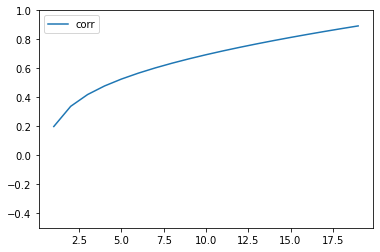

In [50]:
x = [i for i in range(1,20)]
y = [get_decorr_li_wrong(1.6,1.9,1,1,i,0.3,0.3,0.3)[0] for i in range(1,20)]
plt.plot(x,y,label = 'corr')
plt.legend()
plt.ylim(-0.5,1)
plt.show()

In [51]:
get_decorr_li_right(21,21,1,1,20,0.4,0.4,0.4)

(0.47737661716087954,
 0.15032012519613627,
 0.028006536025574055,
 0.14596798922655596)

In [52]:
get_decorr_li_wrong(21,21,1,1,20,0.4,0.4,0.4)

(0.2928253660383308,
 0.08876665718873063,
 0.08876665718873063,
 0.14596798922655596)